In [ ]:
import os

import hydra
import omegaconf
import pyrootutils

root = pyrootutils.setup_root(os.path.abspath("concept_generation_data_auditing.ipynb"), pythonpath=True)

os.chdir(root)

In [ ]:
import sys

sys.path.append(str(root / "src"))

In [ ]:
import os
import time
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import gridspec
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import torch
import tqdm
from IPython import display
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import clip

In [ ]:
# !cp /System/Library/Fonts/Supplemental ~/.local/share/fonts/
# rm -fr ~/.cache/matplotlib
from matplotlib import font_manager
from matplotlib.lines import Line2D
from cycler import cycler
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
font_manager.findfont("Arial") # Test with "Special Elite" too
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.edgecolor']='1.0'
plt.rcParams['legend.framealpha']=0

# https://github.com/dsc/colorbrewer-python/blob/master/colorbrewer.py

Set1 = {
    3: [[228,26,28], [55,126,184], [77,175,74]],
    4: [[228,26,28], [55,126,184], [77,175,74], [152,78,163]],
    5: [[228,26,28], [55,126,184], [77,175,74], [152,78,163], [255,127,0]],
    6: [[228,26,28], [55,126,184], [77,175,74], [152,78,163], [255,127,0], [255,255,51]],
    7: [[228,26,28], [55,126,184], [77,175,74], [152,78,163], [255,127,0], [255,255,51], [166,86,40]],
    8: [[228,26,28], [55,126,184], [77,175,74], [152,78,163], [255,127,0], [255,255,51], [166,86,40], [247,129,191]],
    9: [[228,26,28], [55,126,184], [77,175,74], [152,78,163], [255,127,0], [255,255,51], [166,86,40], [247,129,191], [153,153,153]],
}

Paired = {
    3: [(166,206,227), [31,120,180], [178,223,138]],
    4: [[166,206,227], [31,120,180], [178,223,138], [51,160,44]],
    5: [[166,206,227], [31,120,180], [178,223,138], [51,160,44], [251,154,153]],
    6: [[166,206,227], [31,120,180], [178,223,138], [51,160,44], [251,154,153], [227,26,28]],
    7: [[166,206,227], [31,120,180], [178,223,138], [51,160,44], [251,154,153], [227,26,28], [253,191,111]],
    8: [[166,206,227], [31,120,180], [178,223,138], [51,160,44], [251,154,153], [227,26,28], [253,191,111], [255,127,0]],
    9: [[166,206,227], [31,120,180], [178,223,138], [51,160,44], [251,154,153], [227,26,28], [253,191,111], [255,127,0], [202,178,214]],
    10: [[166,206,227], [31,120,180], [178,223,138], [51,160,44], [251,154,153], [227,26,28], [253,191,111], [255,127,0], [202,178,214], [106,61,154]],
    11: [[166,206,227], [31,120,180], [178,223,138], [51,160,44], [251,154,153], [227,26,28], [253,191,111], [255,127,0], [202,178,214], [106,61,154], [255,255,153]],
    12: [[166,206,227], [31,120,180], [178,223,138], [51,160,44], [251,154,153], [227,26,28], [253,191,111], [255,127,0], [202,178,214], [106,61,154], [255,255,153], [177,89,40]]
}

color_qual_7=['#F53345',
            '#87D303',
            '#04CBCC',
            '#8650CD',
            (160/256, 95/256, 0),
            '#F5A637',              
            '#DBD783',            
             ]

pd.set_option('display.max_rows', 500)

In [ ]:
import scipy.special
import tqdm.contrib.concurrent

In [ ]:
# import importlib
# importlib.reload(sys.modules["MONET.utils.static"])
# from MONET.utils.static import (
#     concept_to_prompt)

In [ ]:
from MONET.datamodules.multiplex_datamodule import MultiplexDatamodule
from MONET.utils.loader import custom_collate_per_key, dataloader_apply_func
from MONET.utils.metrics import skincon_calcualte_auc_all
from MONET.utils.static import (
    concept_to_prompt,
    fitzpatrick17k_disease_label,
    fitzpatrick17k_ninelabel,
    fitzpatrick17k_threelabel,
    skincon_cols,
)
from MONET.utils.text_processing import generate_prompt_token_from_concept

In [ ]:
def wandb_to_exppath(wandb, log_path="/gscratch/cse/chanwkim/MONET_log/train/runs"):
    log_path = Path(log_path)
    for experiment in os.listdir(log_path):
        if os.path.exists(log_path / experiment / "wandb"):
            filenames = os.listdir(log_path / experiment / "wandb")
            filename = [filename for filename in filenames if filename.startswith("run")][0][-8:]
            if filename == wandb:
                return log_path / experiment
    raise RuntimeError("not found")


exppath = wandb_to_exppath(
    wandb="baqqmm5v", log_path="/projects/leelab2/chanwkim/dermatology_datasets/logs/train/runs"
)
print([exppath / "checkpoints" / ckpt for ckpt in os.listdir(exppath / "checkpoints/")])

In [ ]:
variable_dict={}

In [ ]:
def setup_dataloader(dataset_name):    
    if dataset_name=="clinical_fd_clean_nodup":
        cfg_dm = omegaconf.OmegaConf.load(root / "configs" / "datamodule" / "multiplex.yaml")
        # cfg.data_dir="/scr/chanwkim/dermatology_datasets"
        cfg_dm.data_dir = "/sdata/chanwkim/dermatology_datasets"
        cfg_dm.dataset_name_test = "clinical_fd_clean_nodup=all"
        cfg_dm.split_seed = 42

        dm = hydra.utils.instantiate(cfg_dm)
        dm.setup()     
        
        dataloader = dm.test_dataloader()                   
        
    elif dataset_name=="isic":
        cfg_dm = omegaconf.OmegaConf.load(root / "configs" / "datamodule" / "multiplex.yaml")
        # cfg.data_dir="/scr/chanwkim/dermatology_datasets"
        cfg_dm.data_dir = "/sdata/chanwkim/dermatology_datasets"
        cfg_dm.dataset_name_test = "isic=all"
        cfg_dm.split_seed = 42

        dm = hydra.utils.instantiate(cfg_dm)
        dm.setup()     
        
        dataloader = dm.test_dataloader()    
        
    return {"dataloader": dataloader}

In [ ]:
for dataset_name in ["clinical_fd_clean_nodup", "isic"]:  
    variable_dict.setdefault(dataset_name, {})
    variable_dict[dataset_name].update(setup_dataloader(dataset_name))

In [ ]:
!gpustat

# initialize model

In [ ]:
model_name = "zt0n2xd0"
model_device = "cuda:7"

In [ ]:
cfg_model = omegaconf.OmegaConf.load(root / "configs" / "model" / "contrastive.yaml")
cfg_model.net.model_name_or_path = "ViT-L/14"
cfg_model.net.device = model_device
cfg_model

In [ ]:
model = hydra.utils.instantiate(cfg_model)
model.to(model_device)
model.eval()

In [ ]:
model_path_dir = {
    "zt0n2xd0": "logs/train/runs/2023-01-17_20-58-15/checkpoints/last.ckpt",
}
if model_name != "ViT-L/14":
    model_path = model_path_dir[model_name]
    loaded = torch.load(model_path, map_location=model_device)
    model.load_state_dict(loaded["state_dict"])
    print('loaded')

In [ ]:
# torch.save(loaded["state_dict"], "/cse/web/research/aimslab/MONET/weight.pt")

# Image features

In [ ]:
def batch_func(batch):
    with torch.no_grad():
        batch["image"] = batch["image"].to(model_device)
        image_features = model.model_step_with_image(batch)["image_features"]
    # print(batch["metadata"])
    return {
        "image_features": image_features.detach().cpu(),
        "metadata": batch["metadata"],
    }

In [ ]:
def setup_features(dataset_name, dataloader):
    if dataset_name=="isic":
        image_features=torch.load(log_dir/"image_features"/"isic.pt")
        metadata_all=dataloader.dataset.metadata_all
    else:
        loader_applied = dataloader_apply_func(
            dataloader=dataloader,
            func=batch_func,
            collate_fn=custom_collate_per_key,
        )
        image_features = loader_applied["image_features"].cpu()
        metadata_all = loader_applied["metadata"]

    return {"image_features":image_features, "metadata_all": metadata_all}

In [ ]:
log_dir = Path("logs")

In [ ]:
for dataset_name in ["clinical_fd_clean_nodup", "isic"]:
    print(dataset_name)
    variable_dict[dataset_name].update(setup_features(dataset_name, variable_dict[dataset_name]["dataloader"])) 

In [ ]:
diagnosis_malignant_mapping=\
{'AIMP':'indeterminate',
'acrochordon':'benign',
'actinic keratosis':'benign', # 
'angiofibroma or fibrous papule':'benign', 
'angiokeratoma':'benign',
'angioma':'benign',
'atypical melanocytic proliferation':'indeterminate',
'atypical spitz tumor':'indeterminate', #
'basal cell carcinoma':'malignant', #
'cafe-au-lait macule':'benign',
'clear cell acanthoma':'benign',
'dermatofibroma':'benign', #
'lentigo NOS':'benign',
'lentigo simplex':'benign',
'lichenoid keratosis':'benign',
'melanoma':'malignant',
'melanoma metastasis':'malignant',
'neurofibroma':'benign',
'nevus':'benign',
'other':'indeterminate',
'pigmented benign keratosis':'benign', #??
'scar':'benign',
'seborrheic keratosis':'benign',
'solar lentigo':'benign',
'squamous cell carcinoma':'malignant',
'vascular lesion':'unknown', # 
'verruca':'benign'
}

def map_diagnosis_malignant(diagnosis, benign_malignant):
#     if diagnosis=="basal cell carcinoma":
#         print(diagnosis_malignant_mapping[diagnosis], benign_malignant)    
    if isinstance(benign_malignant, str):
        return benign_malignant
    elif diagnosis in diagnosis_malignant_mapping.keys():
        return diagnosis_malignant_mapping[diagnosis]
    elif np.isnan(diagnosis):
        return "indeterminate"
    else:
        raise RuntimeError

In [83]:
def set_config(dataset_name, metadata_all):
    if "clinical_fd_clean" in dataset_name:
        y_pos=(((metadata_all["source"]=="fitz")&(metadata_all["three_partition_label"]=="malignant"))|
              ((metadata_all["source"]=="ddi")&(metadata_all["malignant"] == True))).values
        
        valid_idx=(metadata_all["skincon_Do not consider this image"]!=1).values
        
        concept_list=skincon_cols
        
    elif dataset_name=="isic":  
        metadata_all["benign_malignant_full"]=\
        metadata_all.apply(lambda x: map_diagnosis_malignant(x["diagnosis"], x["benign_malignant"]), axis=1)
        #metadata_all["benign_malignant_full"].value_counts()
        #metadata_all.groupby("diagnosis").apply(lambda x: x["benign_malignant_full"].value_counts())
        metadata_all["benign_malignant_bool"]=metadata_all["benign_malignant_full"].str.contains("malignant")
        
        y_pos=metadata_all["benign_malignant_bool"].values
        
        valid_idx = (metadata_all["benign_malignant_full"].str.contains("malignant")|metadata_all["benign_malignant_full"].str.contains("benign")).values
        
        concept_list=skincon_cols+\
                            ["purple pen", 
                             "nail", 
                             "pinkish", 
                             "red", 
                             "hair", 
                             "orange sticker", 
                             "dermoscope border",
                             "gel",]      
        
        concept_list+=concept_list+\
                        [f"disease_{disease_name}" for disease_name in ['seborrheic keratosis', 'nevus', 'squamous cell carcinoma',
                        'melanoma', 'lichenoid keratosis', 'lentigo',
                        'actinic keratosis', 'basal cell carcinoma', 'dermatofibroma',
                        'atypical melanocytic proliferation', 'verruca',
                        'clear cell acanthoma', 'angiofibroma or fibrous papule', 'scar',
                        'angioma', 'atypical spitz tumor', 'solar lentigo', 'AIMP',
                        'neurofibroma', 'lentigo simplex', 'acrochordon', 
                        'angiokeratoma', 'vascular lesion', 'cafe-au-lait macule',
                        'pigmented benign keratosis']]
        
    return {"valid_idx": valid_idx,
            "y_pos": y_pos,
            "metadata_all": metadata_all,
            "concept_list": concept_list}

In [84]:
for dataset_name in ["clinical_fd_clean_nodup", "isic"]:
    variable_dict[dataset_name].update(
        set_config(dataset_name, variable_dict[dataset_name]["metadata_all"])
    )

In [ ]:
variable_dict["isic"]["metadata_all"][variable_dict["isic"]["metadata_all"]["benign_malignant"]!=variable_dict["isic"]["metadata_all"]["benign_malignant_full"]]["diagnosis"].value_counts()

In [ ]:
def normalize_embedding(dataset_name, image_features):
    #prompt_ref_tokenized = clip.tokenize(prompt_ref, truncate=True)
    #output = model.model_step_with_text({"text": prompt_ref_tokenized.to(model_device)})
    #prompt_ref_embedding=output["text_features"].detach().cpu()
    #prompt_ref_embedding_norm=prompt_ref_embedding/prompt_ref_embedding.norm(dim=1, keepdim=True)      
    
    image_features_norm = image_features / image_features.norm(dim=1, keepdim=True)
    
    return {"image_features_norm": image_features_norm}    

In [ ]:
for dataset_name in ["clinical_fd_clean_nodup", "isic"]:
    variable_dict[dataset_name].update(
    normalize_embedding(dataset_name, 
                        variable_dict[dataset_name]["image_features"])
    )

In [85]:
def get_concept_embedding(dataset_name, concept_list):
    prompt_info={}
    
    for concept_name in concept_list:
        if "clinical_fd_clean" in dataset_name:
            prompt_dict, text_counter = concept_to_prompt(concept_name[8:])
            prompt_engineered_list = []
            for k, v in prompt_dict.items():
                if k != "original":
                    prompt_engineered_list += v    
            concept_term_list = list(set([prompt.replace("This is ", "").replace("This photo is ", "").replace("This lesion is ", "").replace("skin has become ", "").lower()
                                      for prompt in prompt_engineered_list]))
            prompt_template_list=["This is skin image of {}", "This is dermatology image of {}", "This is image of {}"]
            #prompt_target=[prompt_template.format(term) for prompt_template in prompt_template_list for term in concept_term_list]            
            prompt_target=[[prompt_template.format(term) for term in concept_term_list] for prompt_template in prompt_template_list]
            
            prompt_ref = [["This is skin image"], ["This is dermatology image"], ["This is image"]]        
        
        elif dataset_name=="isic":
            if concept_name.startswith("skincon_"):
                prompt_dict, text_counter = concept_to_prompt(concept_name[8:])
                prompt_engineered_list = []
                for k, v in prompt_dict.items():
                    if k != "original":
                        prompt_engineered_list += v

                concept_term_list = list(set([prompt.replace("This is ", "").replace("This photo is ", "").replace("This lesion is ", "").replace("skin has become ", "").lower()
                                          for prompt in prompt_engineered_list]))
                prompt_template_list=["This is dermatoscopy of {}", "This is dermoscopy of {}"]
                prompt_target=[prompt_template.format(term) for prompt_template in prompt_template_list for term in concept_term_list]
                prompt_ref = ["This is dermatoscopy", "This is dermoscopy"]
                prompt_target=[[prompt_template.format(term) for term in concept_term_list] for prompt_template in prompt_template_list]
                prompt_ref = [["This is dermatoscopy"], ["This is dermoscopy"]] 
                
                prompt_target=[[prompt_template.format(term) for prompt_template in prompt_template_list for term in concept_term_list]]
                prompt_ref = [["This is dermatoscopy", "This is dermoscopy"]] 
            elif concept_name.startswith("disease_"):  
                if concept_name=="disease_AIMP":
                    disease_name=concept_name[8:]
                    prompt_target=[["This is dermatoscopy of AIMP",
                                    "This is dermatoscopy of Atypical intraepidermal melanocytic proliferation"],
                                   ["This is dermoscopy of AIMP",
                                    "This is dermoscopy of Atypical intraepidermal melanocytic proliferation"]]
                    prompt_ref = [["This is dermatoscopy"], ["This is dermoscopy"]]
                else:
                    disease_name=concept_name[8:]
                    prompt_target=[[f"This is dermatoscopy of {disease_name}"],
                                   [f"This is dermoscopy of {disease_name}"]] 
                    prompt_ref = [["This is dermatoscopy"], ["This is dermoscopy"]]
                
            else:
                if concept_name=="gel":
                    #concept_term_list=["water drop", 'gel', "fluid"]
                    prompt_target=[["This is dermatoscopy of water drop", "This is dermatoscopy of gel", "This is dermatoscopy of dermoscopy liquid"],
                                   ["This is dermoscopy of water drop", "This is dermoscopy of gel", "This is dermoscopy of dermoscopy liquid"],
                                  ]
                    prompt_target=[["This is dermatoscopy of gel"],
                                   ["This is dermoscopy of gel"],
                                  ]                    
                    
                    prompt_ref = [["This is dermatoscopy"], 
                                  ["This is dermoscopy"]]
                elif concept_name=="dermoscope border":
                    concept_term_list=["dermoscope"]
                    prompt_target=["This is hole"]
                    prompt_target=["This is scope hole", "This is circle", "This is dermoscope"]
                    #prompt_target=[["This is dermatoscopy of dermoscope", "This is dermatoscopy of dermoscopy"]]
                    prompt_target=[["This is dermatoscopy of dermoscopy"]]
                    prompt_ref = [["This is dermatoscopy"]]
                    
                else:
                    concept_term_list=[concept_name]
                    prompt_template_list=["This is dermatoscopy of {}", "This is dermoscopy of {}"]
                    prompt_target=[prompt_template.format(term) for prompt_template in prompt_template_list for term in concept_term_list]
                    
                    prompt_ref = [["This is dermatoscopy"], ["This is dermoscopy"]]
                
        
        #print(prompt_target, prompt_ref)
        # target embedding
        prompt_target_tokenized=[clip.tokenize(prompt_list, truncate=True) for prompt_list in prompt_target]
        with torch.no_grad():
            prompt_target_embedding = torch.stack([model.model_step_with_text({"text": prompt_tokenized.to(model_device)})[
                    "text_features"].detach().cpu() for prompt_tokenized in prompt_target_tokenized])
        prompt_target_embedding_norm=prompt_target_embedding/prompt_target_embedding.norm(dim=2, keepdim=True)          

        # reference embedding
        prompt_ref_tokenized=[clip.tokenize(prompt_list, truncate=True) for prompt_list in prompt_ref]
        with torch.no_grad():
            prompt_ref_embedding = torch.stack([model.model_step_with_text({"text": prompt_tokenized.to(model_device)})[
                    "text_features"].detach().cpu() for prompt_tokenized in prompt_ref_tokenized])
        prompt_ref_embedding_norm=prompt_ref_embedding/prompt_ref_embedding.norm(dim=2, keepdim=True)                

        prompt_info[concept_name]={"prompt_ref_embedding_norm":prompt_ref_embedding_norm,
                                   "prompt_target_embedding_norm":prompt_target_embedding_norm,
                                  }
        print(dataset_name, concept_name, prompt_target, prompt_ref)
        print(prompt_target_embedding_norm)
        print(prompt_ref_embedding_norm)
        del prompt_ref
        del prompt_target
    
    return {"prompt_info": prompt_info}

In [86]:
for dataset_name in ["clinical_fd_clean_nodup", "isic"]:
    variable_dict[dataset_name].update(
        get_concept_embedding(dataset_name, 
                      concept_list=variable_dict[dataset_name]["concept_list"]))

clinical_fd_clean_nodup skincon_Vesicle [['This is skin image of fluid-containing', 'This is skin image of vesicle'], ['This is dermatology image of fluid-containing', 'This is dermatology image of vesicle'], ['This is image of fluid-containing', 'This is image of vesicle']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
tensor([[[-0.0048,  0.0156, -0.0058,  ..., -0.0107, -0.0085, -0.0069],
         [ 0.0009,  0.0164, -0.0013,  ..., -0.0226,  0.0128, -0.0005]],

        [[-0.0175,  0.0348, -0.0225,  ...,  0.0121, -0.0168,  0.0034],
         [-0.0136,  0.0340, -0.0145,  ...,  0.0092,  0.0033,  0.0071]],

        [[-0.0114,  0.0205, -0.0130,  ..., -0.0074, -0.0166, -0.0016],
         [ 0.0042,  0.0181, -0.0018,  ..., -0.0268,  0.0033,  0.0122]]],
       dtype=torch.float16)
tensor([[[ 0.0153,  0.0143,  0.0069,  ..., -0.0244,  0.0140, -0.0112]],

        [[-0.0088,  0.0434, -0.0171,  ...,  0.0084, -0.0046,  0.0017]],

        [[ 0.0105,  0.0196,  0.0105,  ..., 

clinical_fd_clean_nodup skincon_Ulcer [['This is skin image of ulcerated', 'This is skin image of ulcer'], ['This is dermatology image of ulcerated', 'This is dermatology image of ulcer'], ['This is image of ulcerated', 'This is image of ulcer']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
tensor([[[-0.0153, -0.0111, -0.0254,  ..., -0.0145,  0.0112, -0.0102],
         [-0.0116, -0.0013, -0.0151,  ..., -0.0159,  0.0142,  0.0020]],

        [[-0.0274,  0.0027, -0.0306,  ...,  0.0032, -0.0032, -0.0014],
         [-0.0248,  0.0095, -0.0219,  ...,  0.0029,  0.0014,  0.0074]],

        [[-0.0217, -0.0102, -0.0304,  ..., -0.0172,  0.0027,  0.0039],
         [-0.0162,  0.0007, -0.0194,  ..., -0.0161,  0.0022,  0.0155]]],
       dtype=torch.float16)
tensor([[[ 0.0153,  0.0143,  0.0069,  ..., -0.0244,  0.0140, -0.0112]],

        [[-0.0088,  0.0434, -0.0171,  ...,  0.0084, -0.0046,  0.0017]],

        [[ 0.0105,  0.0196,  0.0105,  ..., -0.0319, -0.0104,  0.0042]]],

clinical_fd_clean_nodup skincon_Xerosis [['This is skin image of xerosis', 'This is skin image of dry skin', 'This is skin image of abnormally dry skin'], ['This is dermatology image of xerosis', 'This is dermatology image of dry skin', 'This is dermatology image of abnormally dry skin'], ['This is image of xerosis', 'This is image of dry skin', 'This is image of abnormally dry skin']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
tensor([[[ 0.0244,  0.0267,  0.0264,  ...,  0.0004, -0.0048,  0.0141],
         [ 0.0025,  0.0131,  0.0034,  ..., -0.0014,  0.0323, -0.0105],
         [-0.0062,  0.0221,  0.0089,  ..., -0.0190,  0.0316, -0.0016]],

        [[ 0.0075,  0.0455,  0.0147,  ...,  0.0151, -0.0129,  0.0222],
         [-0.0152,  0.0356, -0.0130,  ...,  0.0195,  0.0121,  0.0034],
         [-0.0207,  0.0418, -0.0019,  ...,  0.0003,  0.0132,  0.0087]],

        [[ 0.0158,  0.0306,  0.0169,  ..., -0.0005, -0.0136,  0.0190],
         [-0.0014,  0.0162,  0.0008

clinical_fd_clean_nodup skincon_Dome-shaped [['This is skin image of like dome'], ['This is dermatology image of like dome'], ['This is image of like dome']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
tensor([[[ 0.0193,  0.0115,  0.0151,  ..., -0.0299,  0.0122,  0.0065]],

        [[ 0.0009,  0.0229, -0.0036,  ..., -0.0027, -0.0001,  0.0160]],

        [[ 0.0205,  0.0116,  0.0176,  ..., -0.0285,  0.0037,  0.0153]]],
       dtype=torch.float16)
tensor([[[ 0.0153,  0.0143,  0.0069,  ..., -0.0244,  0.0140, -0.0112]],

        [[-0.0088,  0.0434, -0.0171,  ...,  0.0084, -0.0046,  0.0017]],

        [[ 0.0105,  0.0196,  0.0105,  ..., -0.0319, -0.0104,  0.0042]]],
       dtype=torch.float16)
clinical_fd_clean_nodup skincon_Flat topped [['This is skin image of flat topped'], ['This is dermatology image of flat topped'], ['This is image of flat topped']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
tensor([[[ 0.0002,  0.0163, -0.006

clinical_fd_clean_nodup skincon_Comedo [['This is skin image of whitehead or blackhead'], ['This is dermatology image of whitehead or blackhead'], ['This is image of whitehead or blackhead']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
tensor([[[-0.0138,  0.0262, -0.0171,  ...,  0.0118,  0.0103,  0.0258]],

        [[-0.0229,  0.0334, -0.0286,  ...,  0.0173,  0.0035,  0.0254]],

        [[-0.0123,  0.0274, -0.0229,  ...,  0.0066, -0.0022,  0.0346]]],
       dtype=torch.float16)
tensor([[[ 0.0153,  0.0143,  0.0069,  ..., -0.0244,  0.0140, -0.0112]],

        [[-0.0088,  0.0434, -0.0171,  ...,  0.0084, -0.0046,  0.0017]],

        [[ 0.0105,  0.0196,  0.0105,  ..., -0.0319, -0.0104,  0.0042]]],
       dtype=torch.float16)
clinical_fd_clean_nodup skincon_Lichenification [['This is skin image of lichenification', 'This is skin image of thickened and leathery'], ['This is dermatology image of lichenification', 'This is dermatology image of thickened and leathe

isic skincon_Vesicle [['This is dermatoscopy of fluid-containing', 'This is dermatoscopy of vesicle', 'This is dermoscopy of fluid-containing', 'This is dermoscopy of vesicle']] [['This is dermatoscopy', 'This is dermoscopy']]
tensor([[[ 0.0049,  0.0432, -0.0172,  ...,  0.0013, -0.0032,  0.0008],
         [ 0.0071,  0.0497, -0.0264,  ..., -0.0090,  0.0273,  0.0056],
         [ 0.0114,  0.0438, -0.0213,  ...,  0.0135, -0.0142, -0.0017],
         [ 0.0115,  0.0474, -0.0211,  ..., -0.0021,  0.0080,  0.0092]]],
       dtype=torch.float16)
tensor([[[ 0.0218,  0.0511, -0.0216,  ..., -0.0051,  0.0121,  0.0029],
         [ 0.0192,  0.0471, -0.0202,  ...,  0.0019, -0.0030,  0.0013]]],
       dtype=torch.float16)
isic skincon_Papule [['This is dermatoscopy of papular', 'This is dermoscopy of papular']] [['This is dermatoscopy', 'This is dermoscopy']]
tensor([[[ 0.0179,  0.0524, -0.0120,  ..., -0.0001, -0.0006,  0.0112],
         [ 0.0211,  0.0504, -0.0109,  ...,  0.0077, -0.0194,  0.0205]]],
   

isic skincon_Exudate [['This is dermatoscopy of exudate', 'This is dermatoscopy of ooze. pus. secretion', 'This is dermoscopy of exudate', 'This is dermoscopy of ooze. pus. secretion']] [['This is dermatoscopy', 'This is dermoscopy']]
tensor([[[ 0.0052,  0.0498, -0.0215,  ...,  0.0030,  0.0126,  0.0094],
         [ 0.0225,  0.0421, -0.0335,  ..., -0.0116,  0.0091, -0.0030],
         [ 0.0057,  0.0447, -0.0238,  ...,  0.0121, -0.0013,  0.0123],
         [ 0.0057,  0.0525, -0.0319,  ..., -0.0052,  0.0082, -0.0063]]],
       dtype=torch.float16)
tensor([[[ 0.0218,  0.0511, -0.0216,  ..., -0.0051,  0.0121,  0.0029],
         [ 0.0192,  0.0471, -0.0202,  ...,  0.0019, -0.0030,  0.0013]]],
       dtype=torch.float16)
isic skincon_Purpura/Petechiae [['This is dermatoscopy of purpura', 'This is dermoscopy of purpura']] [['This is dermatoscopy', 'This is dermoscopy']]
tensor([[[ 0.0181,  0.0278, -0.0336,  ..., -0.0005, -0.0078, -0.0071],
         [ 0.0182,  0.0257, -0.0338,  ...,  0.0042, -0.02

isic skincon_Flat topped [['This is dermatoscopy of flat topped', 'This is dermoscopy of flat topped']] [['This is dermatoscopy', 'This is dermoscopy']]
tensor([[[ 0.0037,  0.0491, -0.0172,  ..., -0.0169,  0.0011,  0.0013],
         [ 0.0072,  0.0495, -0.0213,  ..., -0.0043, -0.0084,  0.0062]]],
       dtype=torch.float16)
tensor([[[ 0.0218,  0.0511, -0.0216,  ..., -0.0051,  0.0121,  0.0029],
         [ 0.0192,  0.0471, -0.0202,  ...,  0.0019, -0.0030,  0.0013]]],
       dtype=torch.float16)
isic skincon_Brown(Hyperpigmentation) [['This is dermatoscopy of brown(hyperpigmentation)', 'This is dermatoscopy of hyperpigmentation', 'This is dermatoscopy of hyperpigmented', 'This is dermoscopy of brown(hyperpigmentation)', 'This is dermoscopy of hyperpigmentation', 'This is dermoscopy of hyperpigmented']] [['This is dermatoscopy', 'This is dermoscopy']]
tensor([[[-0.0003,  0.0460, -0.0244,  ..., -0.0240,  0.0070,  0.0064],
         [-0.0028,  0.0576, -0.0344,  ..., -0.0125,  0.0216,  0.0074],

isic skincon_Wheal [['This is dermatoscopy of urticaria', 'This is dermoscopy of urticaria']] [['This is dermatoscopy', 'This is dermoscopy']]
tensor([[[ 0.0248,  0.0460, -0.0118,  ..., -0.0171,  0.0117, -0.0161],
         [ 0.0217,  0.0481, -0.0095,  ..., -0.0124, -0.0038, -0.0155]]],
       dtype=torch.float16)
tensor([[[ 0.0218,  0.0511, -0.0216,  ..., -0.0051,  0.0121,  0.0029],
         [ 0.0192,  0.0471, -0.0202,  ...,  0.0019, -0.0030,  0.0013]]],
       dtype=torch.float16)
isic skincon_Acuminate [['This is dermatoscopy of acuminate', 'This is dermoscopy of acuminate']] [['This is dermatoscopy', 'This is dermoscopy']]
tensor([[[ 0.0137,  0.0562, -0.0213,  ...,  0.0049,  0.0141,  0.0074],
         [ 0.0139,  0.0505, -0.0228,  ...,  0.0162,  0.0011,  0.0098]]],
       dtype=torch.float16)
tensor([[[ 0.0218,  0.0511, -0.0216,  ..., -0.0051,  0.0121,  0.0029],
         [ 0.0192,  0.0471, -0.0202,  ...,  0.0019, -0.0030,  0.0013]]],
       dtype=torch.float16)
isic skincon_Burrow [[

isic skincon_Papule [['This is dermatoscopy of papular', 'This is dermoscopy of papular']] [['This is dermatoscopy', 'This is dermoscopy']]
tensor([[[ 0.0179,  0.0524, -0.0120,  ..., -0.0001, -0.0006,  0.0112],
         [ 0.0211,  0.0504, -0.0109,  ...,  0.0077, -0.0194,  0.0205]]],
       dtype=torch.float16)
tensor([[[ 0.0218,  0.0511, -0.0216,  ..., -0.0051,  0.0121,  0.0029],
         [ 0.0192,  0.0471, -0.0202,  ...,  0.0019, -0.0030,  0.0013]]],
       dtype=torch.float16)
isic skincon_Macule [['This is dermatoscopy of macule', 'This is dermatoscopy of macular', 'This is dermatoscopy of freckle', 'This is dermatoscopy of lentigo', 'This is dermoscopy of macule', 'This is dermoscopy of macular', 'This is dermoscopy of freckle', 'This is dermoscopy of lentigo']] [['This is dermatoscopy', 'This is dermoscopy']]
tensor([[[ 0.0075,  0.0549, -0.0107,  ..., -0.0053,  0.0188, -0.0103],
         [ 0.0069,  0.0723, -0.0096,  ..., -0.0048, -0.0120,  0.0179],
         [ 0.0155,  0.0405, -0.0

isic skincon_Purpura/Petechiae [['This is dermatoscopy of purpura', 'This is dermoscopy of purpura']] [['This is dermatoscopy', 'This is dermoscopy']]
tensor([[[ 0.0181,  0.0278, -0.0336,  ..., -0.0005, -0.0078, -0.0071],
         [ 0.0182,  0.0257, -0.0338,  ...,  0.0042, -0.0204, -0.0123]]],
       dtype=torch.float16)
tensor([[[ 0.0218,  0.0511, -0.0216,  ..., -0.0051,  0.0121,  0.0029],
         [ 0.0192,  0.0471, -0.0202,  ...,  0.0019, -0.0030,  0.0013]]],
       dtype=torch.float16)
isic skincon_Fissure [['This is dermatoscopy of dry and cracked skin', 'This is dermoscopy of dry and cracked skin']] [['This is dermatoscopy', 'This is dermoscopy']]
tensor([[[ 0.0082,  0.0332, -0.0156,  ...,  0.0064,  0.0244,  0.0016],
         [ 0.0090,  0.0360, -0.0171,  ...,  0.0135,  0.0095,  0.0072]]],
       dtype=torch.float16)
tensor([[[ 0.0218,  0.0511, -0.0216,  ..., -0.0051,  0.0121,  0.0029],
         [ 0.0192,  0.0471, -0.0202,  ...,  0.0019, -0.0030,  0.0013]]],
       dtype=torch.flo

isic skincon_Brown(Hyperpigmentation) [['This is dermatoscopy of brown(hyperpigmentation)', 'This is dermatoscopy of hyperpigmentation', 'This is dermatoscopy of hyperpigmented', 'This is dermoscopy of brown(hyperpigmentation)', 'This is dermoscopy of hyperpigmentation', 'This is dermoscopy of hyperpigmented']] [['This is dermatoscopy', 'This is dermoscopy']]
tensor([[[-0.0003,  0.0460, -0.0244,  ..., -0.0240,  0.0070,  0.0064],
         [-0.0028,  0.0576, -0.0344,  ..., -0.0125,  0.0216,  0.0074],
         [ 0.0036,  0.0402, -0.0229,  ..., -0.0053,  0.0043,  0.0019],
         [-0.0022,  0.0508, -0.0257,  ..., -0.0135, -0.0017,  0.0134],
         [-0.0024,  0.0618, -0.0353,  ..., -0.0058,  0.0081,  0.0137],
         [ 0.0058,  0.0407, -0.0252,  ..., -0.0027, -0.0116,  0.0038]]],
       dtype=torch.float16)
tensor([[[ 0.0218,  0.0511, -0.0216,  ..., -0.0051,  0.0121,  0.0029],
         [ 0.0192,  0.0471, -0.0202,  ...,  0.0019, -0.0030,  0.0013]]],
       dtype=torch.float16)
isic skinc

isic skincon_Acuminate [['This is dermatoscopy of acuminate', 'This is dermoscopy of acuminate']] [['This is dermatoscopy', 'This is dermoscopy']]
tensor([[[ 0.0137,  0.0562, -0.0213,  ...,  0.0049,  0.0141,  0.0074],
         [ 0.0139,  0.0505, -0.0228,  ...,  0.0162,  0.0011,  0.0098]]],
       dtype=torch.float16)
tensor([[[ 0.0218,  0.0511, -0.0216,  ..., -0.0051,  0.0121,  0.0029],
         [ 0.0192,  0.0471, -0.0202,  ...,  0.0019, -0.0030,  0.0013]]],
       dtype=torch.float16)
isic skincon_Burrow [['This is dermatoscopy of scabies', 'This is dermatoscopy of burrow', 'This is dermoscopy of scabies', 'This is dermoscopy of burrow']] [['This is dermatoscopy', 'This is dermoscopy']]
tensor([[[ 0.0232,  0.0491, -0.0112,  ...,  0.0224,  0.0217,  0.0006],
         [ 0.0132,  0.0506, -0.0287,  ..., -0.0243,  0.0039,  0.0029],
         [ 0.0237,  0.0429, -0.0166,  ...,  0.0308,  0.0176, -0.0013],
         [ 0.0131,  0.0499, -0.0297,  ..., -0.0253, -0.0157,  0.0168]]],
       dtype=torc

isic disease_nevus [['This is dermatoscopy of nevus'], ['This is dermoscopy of nevus']] [['This is dermatoscopy'], ['This is dermoscopy']]
tensor([[[ 0.0162,  0.0502, -0.0242,  ..., -0.0137,  0.0086,  0.0059]],

        [[ 0.0208,  0.0474, -0.0279,  ..., -0.0136, -0.0021,  0.0123]]],
       dtype=torch.float16)
tensor([[[ 0.0218,  0.0511, -0.0216,  ..., -0.0051,  0.0121,  0.0028]],

        [[ 0.0191,  0.0471, -0.0201,  ...,  0.0019, -0.0030,  0.0013]]],
       dtype=torch.float16)
isic disease_squamous cell carcinoma [['This is dermatoscopy of squamous cell carcinoma'], ['This is dermoscopy of squamous cell carcinoma']] [['This is dermatoscopy'], ['This is dermoscopy']]
tensor([[[ 0.0225,  0.0246, -0.0213,  ..., -0.0126,  0.0077,  0.0015]],

        [[ 0.0188,  0.0201, -0.0214,  ..., -0.0064,  0.0012,  0.0055]]],
       dtype=torch.float16)
tensor([[[ 0.0218,  0.0511, -0.0216,  ..., -0.0051,  0.0121,  0.0028]],

        [[ 0.0191,  0.0471, -0.0201,  ...,  0.0019, -0.0030,  0.0013]]],


isic disease_AIMP [['This is dermatoscopy of AIMP', 'This is dermatoscopy of Atypical intraepidermal melanocytic proliferation'], ['This is dermoscopy of AIMP', 'This is dermoscopy of Atypical intraepidermal melanocytic proliferation']] [['This is dermatoscopy'], ['This is dermoscopy']]
tensor([[[ 0.0203,  0.0439, -0.0240,  ..., -0.0050, -0.0004,  0.0024],
         [ 0.0066,  0.0306, -0.0355,  ..., -0.0092,  0.0178, -0.0084]],

        [[ 0.0194,  0.0441, -0.0249,  ...,  0.0073, -0.0123,  0.0047],
         [ 0.0062,  0.0344, -0.0401,  ..., -0.0107,  0.0079, -0.0057]]],
       dtype=torch.float16)
tensor([[[ 0.0218,  0.0511, -0.0216,  ..., -0.0051,  0.0121,  0.0028]],

        [[ 0.0191,  0.0471, -0.0201,  ...,  0.0019, -0.0030,  0.0013]]],
       dtype=torch.float16)
isic disease_neurofibroma [['This is dermatoscopy of neurofibroma'], ['This is dermoscopy of neurofibroma']] [['This is dermatoscopy'], ['This is dermoscopy']]
tensor([[[ 0.0271,  0.0468, -0.0150,  ..., -0.0267,  0.0155, -

In [ ]:
!ls logs/experiment_results/data_audit.pt

In [ ]:
variable_dict=torch.load("logs/experiment_results/data_audit_new_0429.pt", map_location="cpu")

In [ ]:
#torch.save(variable_dict, "logs/experiment_results/data_audit_new.pt")

In [ ]:
# torch.save(variable_dict, "logs/experiment_results/data_audit_new_0429.pt")

In [ ]:
variable_dict=torch.load("logs/experiment_results/data_audit_new.pt", map_location="cpu")

In [ ]:
variable_dict["isic"]["image_features_norm"]

In [ ]:
variable_dict["isic"]["prompt_info"]["skincon_Vesicle"]["prompt_target_embedding_norm"]

# image selection

In [ ]:
98.92

In [ ]:
model.net.model??

# concept retrieval

In [ ]:
# def calculate_similaity_score(image_features_norm, 
#                               prompt_target_embedding_norm,
#                               prompt_ref_embedding_norm,
#                               normalize=True):

#     target_similarity=prompt_target_embedding_norm.float()@image_features_norm.T.float()
#     ref_similarity=prompt_ref_embedding_norm.float()@image_features_norm.T.float()
    
    
#     target_similarity_mean=target_similarity.mean(dim=[1])
#     ref_similarity_mean=ref_similarity.mean(axis=1)
         
#     if normalize:
#         similarity_score=scipy.special.softmax([target_similarity_mean.numpy(), 
#                             ref_similarity_mean.numpy()], axis=0)[0,:].mean(axis=0)   
#     else:
#         similarity_score=target_similarity_mean.mean(axis=0)

    
#     return similarity_score

In [ ]:
def calculate_similaity_score(image_features_norm, 
                              prompt_target_embedding_norm,
                              prompt_ref_embedding_norm,
                              temp=1,
                              normalize=True):

    target_similarity=prompt_target_embedding_norm.float()@image_features_norm.T.float()
    ref_similarity=prompt_ref_embedding_norm.float()@image_features_norm.T.float()
    
    
    target_similarity_mean=target_similarity.mean(dim=[1])
    ref_similarity_mean=ref_similarity.mean(axis=1)
         
    if normalize:
        similarity_score=scipy.special.softmax([target_similarity_mean.numpy()/temp, 
                            ref_similarity_mean.numpy()/temp], axis=0)[0,:].mean(axis=0)   
    else:
        similarity_score=target_similarity_mean.mean(axis=0)

    
    return similarity_score

In [ ]:
def shorten_concept_name(concept_name):
    if concept_name=="skincon_Erythema":
        short_name="Erythema"
    elif concept_name=="skincon_Bulla":
        short_name="Bulla"
    elif concept_name=="skincon_Lichenification":
        short_name="Lichenification"
    elif concept_name=="skincon_Pustule":
        short_name="Pustule"
    elif concept_name=="skincon_Ulcer":
        short_name="Ulcer"
    elif concept_name=="skincon_Warty/Papillomatous":
        short_name="Warty"
    elif concept_name=="White(Hypopigmentation)":
        short_name="Hypopigmentation"
    elif concept_name=="purple pen":
        short_name="Purple pen"
    elif concept_name=="nail":
        short_name="Nail"  
    elif concept_name=="orange sticker":
        short_name="Orange sticker"          
    elif concept_name=="hair":
        short_name="Hair"          
    elif concept_name=="gel":
        short_name="Gel"
    elif concept_name=="dermoscope border":
        short_name="Dermoscopic border"
       
    else:
        if concept_name.startswith("skincon_"):
            short_name=concept_name[8:]
            
    return short_name

In [ ]:
def check_image(dataset_name, idx):
    if dataset_name=="clinical_fd_clean_nodup":
        if idx in [2741, 1690, 2894, 2484]:
            return False
        else:
            return True            
    else:
        return True

In [ ]:
def plot_main(dataset_concept_list_list, normalize=True):
    example_per_concept=10


    fig = plt.figure(figsize=(3*(10), 
                              3*(example_per_concept//10)*(len([j for i in dataset_concept_list_list for j in i]))))

    box1 = gridspec.GridSpec(len(dataset_concept_list_list), 1,
                             wspace=0.0,
                             hspace=0.05)

    axd={}
    for idx1, dataset_concept_list in enumerate(dataset_concept_list_list):
        box2 = gridspec.GridSpecFromSubplotSpec(len(dataset_concept_list), 1,
                        subplot_spec=box1[idx1], wspace=0.0, hspace=0.1)

        for idx2, (dataset_name, concept_name) in enumerate(dataset_concept_list):
            box3 = gridspec.GridSpecFromSubplotSpec(example_per_concept//10, 10,
                                                    subplot_spec=box2[idx2], wspace=0, hspace=0.1)
            for rank_num in range(example_per_concept):
                ax=plt.Subplot(fig, box3[rank_num])
                fig.add_subplot(ax)

                plot_key=(idx1, dataset_name, concept_name, rank_num)
                axd[plot_key]=ax

    for idx1, dataset_concept_list in enumerate(dataset_concept_list_list):       
        for idx2, (dataset_name, concept_name) in enumerate(dataset_concept_list):
            similaity_score=calculate_similaity_score(
                            image_features_norm=variable_dict[dataset_name]["image_features_norm"],
                            prompt_target_embedding_norm=variable_dict[dataset_name]["prompt_info"][concept_name]["prompt_target_embedding_norm"],
                            prompt_ref_embedding_norm=variable_dict[dataset_name]["prompt_info"][concept_name]["prompt_ref_embedding_norm"],
                            temp=1/np.exp(4.5944),
                            normalize=normalize)            

            image_idx_list=pd.Series(similaity_score)[(variable_dict[dataset_name]["valid_idx"])].sort_values(ascending=False).index.tolist()

            count=0
            rank_num=0
            while rank_num<example_per_concept:
                if check_image(dataset_name, image_idx_list[count]):
                    pass
                else:
                    print('error',dataset_name,concept_name, image_idx_list[count])
                    count+=1
                    continue
                    
                plot_key=(idx1, dataset_name, concept_name, rank_num)
                
                image=variable_dict[dataset_name]["dataloader"].dataset.getitem(image_idx_list[count])["image"]
                axd[plot_key].imshow(image.resize((300, 300)))

                axd[plot_key].set_xticks([])
                axd[plot_key].set_yticks([])        

                if rank_num==0:   
                    axd[plot_key].set_ylabel(shorten_concept_name(concept_name), fontsize=30, zorder=-10)

                if rank_num==0 and idx2==0:
                      axd[plot_key].text(x=-0.3, y=1.05, transform=axd[plot_key].transAxes,
                                         s=["A", "B", "C", "D", "E"][idx1], fontsize=35, weight='bold')

                for axis in ['top','bottom','left','right']:
                    axd[plot_key].spines[axis].set_linewidth(1)      
                    
                rank_num+=1
                count+=1
    return fig

In [ ]:
fig=plot_main(dataset_concept_list_list=[
    [
        ("clinical_fd_clean_nodup", "skincon_Erythema"),
        ("clinical_fd_clean_nodup", "skincon_Bulla"),  
        ("clinical_fd_clean_nodup", "skincon_Xerosis"),
        ("clinical_fd_clean_nodup", "skincon_Pustule"),
        ("clinical_fd_clean_nodup", "skincon_Ulcer"),
    ],
    [
        ("isic", "skincon_Erythema"),
        ("isic", "skincon_Blue"),  
        ("isic", "skincon_Nodule"),
        ("isic", "skincon_Ulcer"),    
        ("isic", "skincon_Warty/Papillomatous"),
    ]    
])

# fig.savefig(log_dir/"plots"/"main_example.png", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"main_example.jpg", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"main_example.svg", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"main_example.pdf", bbox_inches='tight')
# plt.close(fig)

In [ ]:
def plot_supplement(dataset_concept_list_list, debug=True, normalize=True):
    example_per_concept=30


    fig = plt.figure(figsize=(3*(10), 
                              3*(example_per_concept//10)*(len([j for i in dataset_concept_list_list for j in i]))))

    box1 = gridspec.GridSpec(len(dataset_concept_list_list), 1,
                             wspace=0.0,
                             hspace=0.1)

    axd={}
    for idx1, dataset_concept_list in enumerate(dataset_concept_list_list):
        box2 = gridspec.GridSpecFromSubplotSpec(len(dataset_concept_list), 1,
                        subplot_spec=box1[idx1], wspace=0.0, hspace=0.1)


        #axd[plot_key].set_title(["A", "B", "C", "D", "E"][idx1], fontsize=30, loc="left")
        for idx2, (dataset_name, concept_name) in enumerate(dataset_concept_list):
            box3 = gridspec.GridSpecFromSubplotSpec(example_per_concept//10, 10,
                                                    subplot_spec=box2[idx2], wspace=0, hspace=0.1)
            for rank_num in range(example_per_concept):
                ax=plt.Subplot(fig, box3[rank_num])
                fig.add_subplot(ax)

                plot_key=(idx1, dataset_name, concept_name, rank_num)
                axd[plot_key]=ax

        pass

    for idx1, dataset_concept_list in enumerate(dataset_concept_list_list):       
        for idx2, (dataset_name, concept_name) in enumerate(dataset_concept_list):
            similaity_score=calculate_similaity_score(
                            image_features_norm=variable_dict[dataset_name]["image_features_norm"],
                            prompt_target_embedding_norm=variable_dict[dataset_name]["prompt_info"][concept_name]["prompt_target_embedding_norm"],
                            prompt_ref_embedding_norm=variable_dict[dataset_name]["prompt_info"][concept_name]["prompt_ref_embedding_norm"],
                            normalize=normalize)

            image_idx_list=pd.Series(similaity_score)[(variable_dict[dataset_name]["valid_idx"])].sort_values(ascending=False).index.tolist()

            count=0
            rank_num=0
            while rank_num<example_per_concept:
                if check_image(dataset_name, image_idx_list[count]):
                    pass
                else:
                    print('error',dataset_name,concept_name, image_idx_list[count])
                    count+=1
                    continue

                plot_key=(idx1, dataset_name, concept_name, rank_num)

                image=variable_dict[dataset_name]["dataloader"].dataset.getitem(image_idx_list[count])["image"]
                axd[plot_key].imshow(image.resize((300, 300)))
                
#                 axd[plot_key].set_title(image_idx_list[count])

                axd[plot_key].set_xticks([])
                axd[plot_key].set_yticks([])     
                
                if debug:
                    axd[plot_key].set_title(image_idx_list[count])
                    

                if rank_num==0:   
                    axd[plot_key].text(x=-0.0, y=1.06, transform=axd[plot_key].transAxes,
                                       s=shorten_concept_name(concept_name), fontsize=35, zorder=-10)

                if rank_num==0 and idx2==0:
                      axd[plot_key].text(x=-0.3, y=1.06, transform=axd[plot_key].transAxes,
                                         s=["A.", "B.", "C.", "D.", "E."][idx1], fontsize=35, weight='bold')

    #             if len(dataset_concept_list_list)>0:
    #                 subfigs_main[idx0].suptitle({0: "A", 1: "B"}[idx0], fontsize=45, weight='bold', x=0, zorder=10)                

                for axis in ['top','bottom','left','right']:
                    axd[plot_key].spines[axis].set_linewidth(1.5) 
                
                rank_num+=1
                count+=1                
                
    return fig

In [ ]:
def temp():
    metadata_temp=variable_dict["clinical_fd_clean_nodup"]["metadata_all"]
    skincon_idx=(metadata_temp["skincon_Do not consider this image"]==0).values
    for tone_split in ["all", "12", "34", "56"]:
        if tone_split=="all":
            tone_idx=((metadata_temp["fitzpatrick_scale"].fillna(-9).astype(int).isin([1,2,3,4,5,6,-9]))|\
                    (metadata_temp["skin_tone"].fillna(-9).astype(int).isin([12,34,56,-9]))).values
        elif tone_split=="12":
            tone_idx=((metadata_temp["fitzpatrick_scale"].fillna(-9).astype(int).isin([1,2]))|\
                    (metadata_temp["skin_tone"].fillna(-9).astype(int).isin([12]))).values
        elif tone_split=="34":
            tone_idx=((metadata_temp["fitzpatrick_scale"].fillna(-9).astype(int).isin([3,4]))|\
                    (metadata_temp["skin_tone"].fillna(-9).astype(int).isin([34]))).values
        elif tone_split=="56":
            tone_idx=((metadata_temp["fitzpatrick_scale"].fillna(-9).astype(int).isin([5,6]))|\
                    (metadata_temp["skin_tone"].fillna(-9).astype(int).isin([56]))).values        
        print(tone_split)
        print(tone_idx.shape, tone_idx.sum())
        print(skincon_idx.shape, skincon_idx.sum())
        print((skincon_idx&tone_idx).shape, (skincon_idx&tone_idx).sum())
temp()        

In [ ]:
variable_dict["clinical_fd_clean_nodup"]["metadata_all"]["source"].fillna(0).value_counts()

Erythema
2741 720cf31558966c82c118ab75b50632eb.jpg
1690 58b4bc079ca94e6e9377a42ca7564b40.jpg
2894 5f046cda32a3cc547205662e7be774f9.jpg

Ulcer
2484 d8bf377acc45a3beb0c6e81bf7ac1ff5.jpg

In [ ]:
# variable_dict["clinical_fd_clean_nodup"]["dataloader"].dataset.getitem(2484)["image"].resize((300,300))

In [ ]:
fig=plot_supplement(dataset_concept_list_list=[
        [("clinical_fd_clean_nodup", "skincon_Erythema")],
        [("clinical_fd_clean_nodup", "skincon_Bulla")],  
        [("clinical_fd_clean_nodup", "skincon_Xerosis")],
        [("clinical_fd_clean_nodup", "skincon_Pustule")],
        [("clinical_fd_clean_nodup", "skincon_Ulcer")],
], debug=False)
# fig.savefig(log_dir/"plots"/"supple_example_clinical.png", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"supple_example_clinical.jpg", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"supple_example_clinical.svg", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"supple_example_clinical.pdf", bbox_inches='tight')
# plt.close(fig)

In [ ]:
fig=plot_supplement(dataset_concept_list_list=[
        [("isic", "skincon_Erythema")],
        [("isic", "skincon_Blue")],  
        [("isic", "skincon_Nodule")],
        [("isic", "skincon_Ulcer")],
        [("isic", "skincon_Warty/Papillomatous")],
], debug=False)
# fig.savefig(log_dir/"plots"/"supple_example_dermoscopy.png", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"supple_example_dermoscopy.jpg", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"supple_example_dermoscopy.svg", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"supple_example_dermoscopy.pdf", bbox_inches='tight')
# plt.close(fig)

In [ ]:
fig=plot_supplement(dataset_concept_list_list=[
        [("isic", "purple pen")],
        [("isic", "orange sticker")],  
        [("isic", "nail")],
        [("isic", "hair")],
        [("isic", "dermoscope border")],
], debug=False)
# fig.savefig(log_dir/"plots"/"supple_example_dermoscopy_confounder.png", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"supple_example_dermoscopy_confounder.jpg", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"supple_example_dermoscopy_confounder.svg", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"supple_example_dermoscopy_confounder.pdf", bbox_inches='tight')
# plt.close(fig)

In [54]:
def perform_benchmark(metadata_all, image_features_norm, valid_idx, prompt_info, replace=True, min_sample=30):
    benchmark_dict_list=[]
    #for concept_name_target in tqdm.tqdm(prompt_info.keys()):
    for concept_name_target in tqdm.tqdm(skincon_cols):
        metadata_all_valid=metadata_all.reset_index()[valid_idx]
        
        if (metadata_all_valid[concept_name_target]==1).values.sum()<min_sample:
            continue
        if (metadata_all_valid[concept_name_target]==0).values.sum()<min_sample:
            continue        
        
        if concept_name_target not in metadata_all_valid.columns:
            print(f"Omitted {concept_name_target}")
            continue
            
        #for num_sample in [25, 50, 100, 200, 400]:
        for num_sample in [100]:
        #for num_sample in [100]:
            # for noise_level in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
            for noise_level in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
            #for noise_level in [0.2]:
                for random_seed in range(20):
                #for random_seed in [1]:                    
                    num_false = int(num_sample*noise_level)
                    num_true = num_sample-num_false
                    #print(num_true, num_false)
                    
                    if replace:
                        idx_pos_true=metadata_all_valid[(metadata_all_valid[concept_name_target]==1).values].sample(n=num_true, replace=True, random_state=random_seed).index
                        idx_pos_false=metadata_all_valid[(metadata_all_valid[concept_name_target]==0).values].sample(n=num_false, replace=True, random_state=random_seed).index
                        # idx_pos_false=metadata_all_valid[(metadata_all_valid[concept_name_target]!=-1).values].sample(n=num_false, replace=True, random_state=random_seed).index
                        idx_neg_true=metadata_all_valid[(metadata_all_valid[concept_name_target]==0).values].sample(n=num_true, replace=True, random_state=random_seed).index
                        idx_neg_false=metadata_all_valid[(metadata_all_valid[concept_name_target]==1).values].sample(n=num_false, replace=True, random_state=random_seed).index
                        # idx_neg_false=metadata_all_valid[(metadata_all_valid[concept_name_target]!=-1).values].sample(n=num_false, replace=True, random_state=random_seed).index
                        
                        idx_pos=idx_pos_true.tolist()+idx_pos_false.tolist()
                        idx_neg=idx_neg_true.tolist()+idx_neg_false.tolist()
                    else:
                        if (metadata_all_valid[concept_name_target]==1).values.sum()<num_sample:
                            continue
                        if (metadata_all_valid[concept_name_target]==0).values.sum()<num_sample:
                            continue
                        
                        idx_pos_true=metadata_all_valid[(metadata_all_valid[concept_name_target]==1).values].sample(n=num_true, replace=False, random_state=random_seed).index
                        idx_pos_false=metadata_all_valid[(metadata_all_valid[concept_name_target]==0).values].sample(n=num_false, replace=False, random_state=random_seed).index
                        idx_neg_true=metadata_all_valid[(metadata_all_valid[concept_name_target]==0).values].sample(n=num_true, replace=False, random_state=random_seed).index
                        idx_neg_false=metadata_all_valid[(metadata_all_valid[concept_name_target]==1).values].sample(n=num_false, replace=False, random_state=random_seed).index
                        
                        idx_pos=idx_pos_true.tolist()+idx_pos_false.tolist()
                        idx_neg=idx_neg_true.tolist()+idx_neg_false.tolist()                        

                    #print(len(idx_pos_true), len(idx_pos_false), len(idx_pos))
                    #print(len(idx_neg_true), len(idx_neg_false), len(idx_neg))
                    image_features_norm_pos=image_features_norm[idx_pos].float().numpy()
                    image_features_norm_neg=image_features_norm[idx_neg].float().numpy()

                    image_features_norm_pos_mean=image_features_norm_pos.mean(axis=0)
                    image_features_norm_neg_mean=image_features_norm_neg.mean(axis=0)
                    #image_features_pos_mean=image_features_pos.mean(axis=0)

                    #print(image_features_norm_pos_mean.shape, image_features_norm_neg_mean.shape)
                    #image_features_neg_mean=image_features_neg.mean(axis=0)    

                    image_features_norm_diff=(image_features_norm_pos_mean-image_features_norm_neg_mean)

                    record_dict_list=[]
                    #for concept_name_test in prompt_info.keys():
                    for concept_name_test in skincon_cols:
                        concept_test_embedding_norm=prompt_info[concept_name_test]["prompt_target_embedding_norm"].numpy() #concept_embedding_dict[concept_name]
                        concept_test_embedding_norm_mean=concept_test_embedding_norm.mean(axis=(0,1))
                        record_dict_list.append({"concept_name_test": concept_name_test,
                                                 "value": (image_features_norm_diff@concept_test_embedding_norm_mean).item()
                                                 })

#                     print(concept_name_target, noise_level, pd.DataFrame(record_dict_list).sort_values('value', ascending=False)["concept_name_test"].tolist())
                    rank=pd.DataFrame(record_dict_list).sort_values('value', ascending=False)["concept_name_test"].tolist().index(concept_name_target)
                    percentile=rank/len(record_dict_list)
                    #print(concept_name_target, pd.DataFrame(record_dict_list).sort_values('value', ascending=False).iloc[:5])


                    benchmark_dict_list.append({"concept_name_target": concept_name_target,
                                                "num_sample": num_sample,
                                                "noise_level": noise_level,
                                                "random_seed": random_seed,                                                
                                                "rank": rank,                                                                                     
                                                "percentile": percentile,
                                                "1-percentile": 1-percentile,
                                               })
            #print(concept_name_target, pd.DataFrame(benchmark_dict_list_temp).sort_values("value", ascending=False).iloc[:5])
    return {"benchmark_dict_list":
            benchmark_dict_list}

In [55]:
for dataset_name in ["clinical_fd_clean_nodup"]: 
    x=perform_benchmark(
        metadata_all=variable_dict[dataset_name]["metadata_all"],
        image_features_norm=variable_dict[dataset_name]["image_features_norm"],
        valid_idx=variable_dict[dataset_name]["valid_idx"],
        prompt_info=variable_dict[dataset_name]["prompt_info"],
        min_sample=30)
#     variable_dict[dataset_name].update(x)

100%|███████████████████████████████████████████| 48/48 [00:30<00:00,  1.58it/s]


In [ ]:
len(x["benchmark_dict_list"])

In [ ]:
21*20*6

In [ ]:
(~variable_dict[dataset_name]["valid_idx"]).sum()

In [56]:
def top_n_accuracy(rank_all):
    rank_all_top1=rank_all.copy()
    rank_all_top1["top_n"]=1
    rank_all_top1["accuracy"]=(rank_all_top1["rank"]<1).astype(int)

    rank_all_top2=rank_all.copy()
    rank_all_top2["top_n"]=2
    rank_all_top2["accuracy"]=(rank_all_top2["rank"]<2).astype(int)

    rank_all_top3=rank_all.copy()
    rank_all_top3["top_n"]=3
    rank_all_top3["accuracy"]=(rank_all_top3["rank"]<3).astype(int)
    
    rank_all_top4=rank_all.copy()
    rank_all_top4["top_n"]=4
    rank_all_top4["accuracy"]=(rank_all_top4["rank"]<4).astype(int)    

    rank_all_top5=rank_all.copy()
    rank_all_top5["top_n"]=5
    rank_all_top5["accuracy"]=(rank_all_top5["rank"]<5).astype(int)
    
    rank_all_top=pd.concat([rank_all_top1,
                            rank_all_top2,
                            rank_all_top3,
                            rank_all_top4,                            
                            rank_all_top5])    
    return rank_all_top

In [57]:
#benchmark_df=pd.DataFrame(variable_dict['clinical_fd_clean']["benchmark_dict_list"])
benchmark_df=pd.DataFrame(x["benchmark_dict_list"])
rank_all_top=top_n_accuracy(benchmark_df)

In [ ]:
len(rank_all_top["concept_name_target"].unique())

In [ ]:
len(rank_all_top["concept_name_target"].value_counts())

In [ ]:
rank_all_top

In [ ]:
rank_all_top[(rank_all_top["num_sample"]==100)&(rank_all_top["noise_level"]!=0.3)&(rank_all_top["noise_level"]!=0.5)]\
.groupby(["top_n", "noise_level", "concept_name_target"])["accuracy"].mean().reset_index()

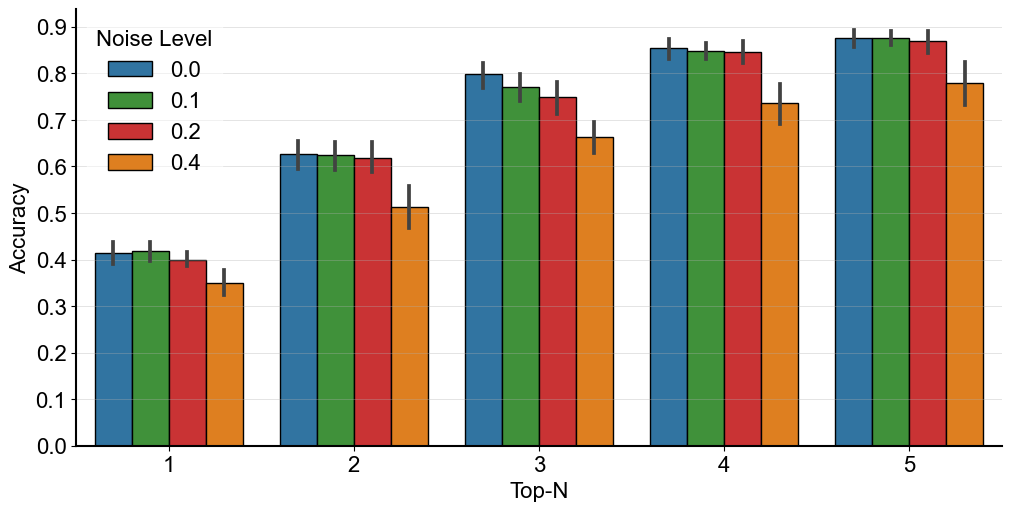

In [58]:
# plt.rcParams["axes.prop_cycle"]=cycler('color',color_qual_7)
plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in [Paired[12][1], 
                                                                                Paired[12][3],
                                                                                Paired[12][5],
                                                                                Paired[12][7],
                                                                                Paired[12][9],
                                                                                Paired[12][11]
                                                                                ]])
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
subfigs = fig.subfigures(1, 1)

ax = subfigs.subplots(1,1)


# sns.barplot(x="top_n", y="accuracy", hue="noise_level", 
#             data=rank_all_top[(rank_all_top["num_sample"]==100)&(rank_all_top["noise_level"]!=0.3)&(rank_all_top["noise_level"]!=0.5)],
#            ax=ax)

# rank_all_top_group=rank_all_top[(rank_all_top["num_sample"]==100)&(rank_all_top["noise_level"]!=0.3)&(rank_all_top["noise_level"]!=0.5)]\
# .groupby(["top_n", "noise_level"])["accuracy"].mean().reset_index()
# sns.barplot(x="top_n", y="accuracy", hue="noise_level", 
#             data=rank_all_top_group,
#            ax=ax)

rank_all_top_group=rank_all_top[(rank_all_top["num_sample"]==100)&(rank_all_top["noise_level"]!=0.3)&(rank_all_top["noise_level"]!=0.5)]\
.groupby(["top_n", "noise_level", "random_seed"])["accuracy"].mean().reset_index()
sns.barplot(x="top_n", y="accuracy", hue="noise_level", 
            data=rank_all_top_group,
           ax=ax)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.grid(True, which='major', linewidth=0.4, alpha=0.6)
ax.yaxis.grid(True, which='minor', linewidth=0.4, alpha=0.2)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.set_xlabel("Top-N", fontsize=16)
ax.set_ylabel("Accuracy", fontsize=16)

# ax.set_title("Evaluation of Data Auditing Framework", pad=10, fontsize=16)

for patch in ax.patches :
    patch.set_linewidth(1)
    patch.set_edgecolor("black")

leg=ax.legend(fontsize = 16, facecolor='white', framealpha=0.5)
leg.set_title("Noise Level", prop={"size":16})

# fig.savefig(log_dir/"plots"/"supple_data_audit_eval.png", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"supple_data_audit_eval.jpg", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"supple_data_audit_eval.svg", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"supple_data_audit_eval.pdf", bbox_inches='tight')
# plt.close(fig)

In [59]:
from collections import OrderedDict
collection_id_mapping=OrderedDict(((61, "Challenge 2016: Test"),
(74, "Challenge 2016: Training"),
(69, "Challenge 2017: Test"),
(60, "Challenge 2017: Training"),
(71, "Challenge 2017: Validation"),
(63, "Challenge 2018: Task 1-2: Training"),
(66, "Challenge 2018: Task 3: Training"),
(65, "Challenge 2019: Training"),
(70, "Challenge 2020: Training"),
(97, "Collection for ISBI 2016: 100 Lesion Classification"),
(162, "Consecutive biopsies for melanoma across year 2020"),
(75, "Consumer AI apps"),
(166, "EASY Dermoscopy Expert Agreement Study"),
(168, "Longitudinal overview images of posterior trunks"),
(163, "MSKCC Consecutive biopsies across year 2020_cohort"),
(77, "Melanocytic lesions used for dermoscopic feature annotations"),
(170, "PROVe-AI"),
# (172, "screenshot_public_230207"))
))
def shorten_collection_name(name):
    return name.replace("Challenge ","")
def shorten_attribution_name(name, very_short=True):
    if very_short:
        mapping_dict={'Hospital Clínic de Barcelona': "Barcelona",
        'ViDIR Group, Department of Dermatology, Medical University of Vienna': "Vienna",
        'Department of Dermatology, Hospital Clínic de Barcelona': "Barcelona2",
        'Pascale Guitera': "Pascale Guitera",
        'MSKCC': "MSKCC1",
        'Memorial Sloan Kettering Cancer Center': "MSKCC2"}        
    else:
        mapping_dict={'Hospital Clínic de Barcelona': "Barcelona",
        'ViDIR Group, Department of Dermatology, Medical University of Vienna': "Med Univ. of Vienna",
        'Department of Dermatology, Hospital Clínic de Barcelona': "Barcelona Hospital2",
        'Pascale Guitera': "Pascale Guitera",
        'MSKCC': "MSKCC1",
        'Memorial Sloan Kettering Cancer Center': "MSKCC2"}
    
    if name in mapping_dict.keys():
        return mapping_dict[name]
    else:
        return name

In [60]:
def make_collection_statistics(dataset_name, metadata_all, valid_idx):    
    if dataset_name=="isic":
        metadata_all["attribution"]=metadata_all["attribution"].str.replace("ViDIR group", "ViDIR Group")
        columns_collection=["collection_"+str(key) for key in collection_id_mapping.keys()]

        collection_statistics_malignant=\
        metadata_all[valid_idx][metadata_all[valid_idx]["benign_malignant_bool"]].groupby("attribution").apply(lambda x: x[columns_collection].sum())
        collection_statistics_benign=\
        metadata_all[valid_idx][~metadata_all[valid_idx]["benign_malignant_bool"]].groupby("attribution").apply(lambda x: x[columns_collection].sum())
        collection_statistics=(collection_statistics_malignant.astype(str)+" / "+collection_statistics_benign.astype(str)).fillna("0 / 0")
        
#         collection_statistics.columns=\
#         collection_statistics.columns.map(lambda x: collection_id_mapping[int(x.split('_')[-1])])
#         collection_statistics
    
    return {"collection_statistics": collection_statistics}

In [61]:
for dataset_name in ["isic"]: 
    x=make_collection_statistics(
        dataset_name=dataset_name,
        metadata_all=variable_dict[dataset_name]["metadata_all"],
        valid_idx=variable_dict[dataset_name]["valid_idx"])
    variable_dict[dataset_name].update(x)
# variable_dict[dataset_name]["collection_statistics"].rename(columns={f"collection_{key}":value for key, value in collection_id_mapping.items()})    

In [62]:
#variable_dict['isic']["collection_statistics"]

In [63]:
def get_subset_index(dataset_name, metadata_all, attribution):
    if dataset_name=="isic":
        if attribution=="all":
            #pd.Series([True], index=metadata_all)
            subset_idx=np.array([True]*len(metadata_all))
        else:
            collection_65=(metadata_all["collection_65"]==1).values
            
            if attribution=="barcelona_all":
                subset_idx=((metadata_all["attribution"]=="Department of Dermatology, Hospital Clínic de Barcelona")|(metadata_all["attribution"]=="Hospital Clínic de Barcelona")).values
            elif attribution=="mskcc_all":
                subset_idx=((metadata_all["attribution"]=="MSKCC")|(metadata_all["attribution"]=="Memorial Sloan Kettering Cancer Center")).values
            else:
                subset_idx=(metadata_all["attribution"]==attribution).values          
                
            subset_idx=subset_idx&collection_65
        #for attribution in [None]+["barcelona", "vienna", "barcelona_all"]:
        #for attribution in ["all"]+list(metadata_all["attribution"].unique())+["barcelona_all", "mskcc_all"]:
  
                    
    return subset_idx

In [87]:
def diff_test(image_features_norm, embedding_dict, idx_pos, idx_neg):
    image_features_norm_pos=image_features_norm[idx_pos].float().numpy()
    image_features_norm_neg=image_features_norm[idx_neg].float().numpy()

    image_features_norm_pos_mean=image_features_norm_pos.mean(axis=0)
    image_features_norm_neg_mean=image_features_norm_neg.mean(axis=0)

    image_features_norm_diff=(image_features_norm_pos_mean-image_features_norm_neg_mean)            

    result_dict={}
    for concept_name, embedding_norm in embedding_dict.items():
        embedding_norm=embedding_dict[concept_name]
        embedding_norm_mean=embedding_norm.numpy().mean(axis=(0,1))
        diff_score=(image_features_norm_diff@embedding_norm_mean).item()
        result_dict[concept_name]=diff_score
        
    return result_dict

In [88]:
def make_concept_diff_sole(dataset_name, image_features_norm, metadata_all, y_pos, valid_idx, prompt_info, attribution_list):
    if dataset_name=="isic":
        diff_score_dict={}
        #for attribution in [None]+["barcelona", "vienna", "barcelona_all"]:
        #for attribution in ["all"]+list(metadata_all["attribution"].unique())+["barcelona_all", "mskcc_all"]:
        for attribution in attribution_list:
            subset_idx=get_subset_index(dataset_name=dataset_name, metadata_all=metadata_all, attribution=attribution)
            
            idx_pos=(y_pos==True)&(valid_idx==True)&(subset_idx)
            idx_neg=(y_pos==False)&(valid_idx==True)&(subset_idx)
            
            if idx_pos.sum()==0 or idx_neg.sum()==0:
                print(f"- {attribution} pos: {(idx_pos.sum())} neg: {(idx_neg.sum())}")
                continue
            else:
                print(f"+ {attribution} pos: {(idx_pos.sum())} neg: {(idx_neg.sum())}")
                                             
            result_dict=diff_test(image_features_norm=image_features_norm, embedding_dict={concept_name:prompt_info[concept_name]["prompt_target_embedding_norm"] for concept_name in prompt_info.keys()},
                                  idx_pos=idx_pos, idx_neg=idx_neg)
                
            diff_score_dict[attribution]=result_dict
        
    return {"concept_diff_sole": diff_score_dict}

for dataset_name in ["isic"]: 
    x=make_concept_diff_sole(dataset_name=dataset_name, 
                      image_features_norm=variable_dict[dataset_name]["image_features_norm"],                      
                      metadata_all=variable_dict[dataset_name]["metadata_all"],
                      y_pos=variable_dict[dataset_name]["y_pos"],
                      valid_idx=variable_dict[dataset_name]["valid_idx"],
                      prompt_info=variable_dict[dataset_name]["prompt_info"],   
                      attribution_list=["all"]+['Memorial Sloan Kettering Cancer Center',
                                       'Attributed to Konstantinos Liopyris',
                                       'For educational purpose only',
                                       'Department of Dermatology, Hospital Clínic de Barcelona',
                                       'Pascale Guitera',
                                       'The University of Queensland Diamantina Institute, The University of Queensland, Dermatology Research Centre',
                                       'ViDIR Group, Department of Dermatology, Medical University of Vienna',
                                       'MSKCC', 'Hospital Clínic de Barcelona', 'Anonymous',
                                       'Dermoscopedia']+["barcelona_all", "mskcc_all"])
    variable_dict[dataset_name].update(x)

+ all pos: 10091 neg: 61151
- Memorial Sloan Kettering Cancer Center pos: 0 neg: 0
- Attributed to Konstantinos Liopyris pos: 0 neg: 0
- For educational purpose only pos: 0 neg: 0
- Department of Dermatology, Hospital Clínic de Barcelona pos: 0 neg: 0
- Pascale Guitera pos: 0 neg: 0
- The University of Queensland Diamantina Institute, The University of Queensland, Dermatology Research Centre pos: 0 neg: 0
+ ViDIR Group, Department of Dermatology, Medical University of Vienna pos: 1824 neg: 8049
- MSKCC pos: 0 neg: 0
+ Hospital Clínic de Barcelona pos: 6097 neg: 6205
+ Anonymous pos: 553 neg: 2345
- Dermoscopedia pos: 0 neg: 0
+ barcelona_all pos: 6097 neg: 6205
- mskcc_all pos: 0 neg: 0


In [89]:
6097+6205

12302

In [90]:
1824+8049

9873

In [91]:
def make_concept_diff_cross(dataset_name, image_features_norm, metadata_all, y_pos, valid_idx, prompt_info, attribution_pair_list):
    diff_score_dict={}
    for attribution_name_1, attribution_name_2 in attribution_pair_list:
        subset_idx_1=get_subset_index(dataset_name=dataset_name, metadata_all=metadata_all, attribution=attribution_name_1)
        subset_idx_2=get_subset_index(dataset_name=dataset_name, metadata_all=metadata_all, attribution=attribution_name_2)
        
        idx_pos=(valid_idx==True)&(subset_idx_1)
        idx_neg=(valid_idx==True)&(subset_idx_2) 
        
        if idx_pos.sum()==0 or idx_neg.sum()==0:
            print(f"- {(attribution_name_1, attribution_name_2)} pos: {(idx_pos.sum())} neg: {(idx_neg.sum())}")
            continue
        else:
            print(f"+ {(attribution_name_1, attribution_name_2)} pos: {(idx_pos.sum())} neg: {(idx_neg.sum())}")        
        
        result_dict=diff_test(image_features_norm=image_features_norm, embedding_dict={concept_name:prompt_info[concept_name]["prompt_target_embedding_norm"] for concept_name in prompt_info.keys()},
                              idx_pos=idx_pos, idx_neg=idx_neg)
        diff_score_dict[(attribution_name_1, attribution_name_2)]=result_dict
        
    return {"concept_diff_cross": diff_score_dict}

for dataset_name in ["isic"]: 
    x=make_concept_diff_cross(dataset_name=dataset_name, 
                      image_features_norm=variable_dict[dataset_name]["image_features_norm"],                      
                      metadata_all=variable_dict[dataset_name]["metadata_all"],
                      y_pos=variable_dict[dataset_name]["y_pos"],
                      valid_idx=variable_dict[dataset_name]["valid_idx"],
                      prompt_info=variable_dict[dataset_name]["prompt_info"],   
                      attribution_pair_list=[("Hospital Clínic de Barcelona", "ViDIR Group, Department of Dermatology, Medical University of Vienna")],
                     )
    variable_dict[dataset_name].update(x)    

+ ('Hospital Clínic de Barcelona', 'ViDIR Group, Department of Dermatology, Medical University of Vienna') pos: 12302 neg: 9873


In [ ]:
diff_temp=pd.Series(variable_dict[dataset_name]["concept_diff_sole"]['Hospital Clínic de Barcelona'])\
-pd.Series(variable_dict[dataset_name]["concept_diff_sole"]['ViDIR Group, Department of Dermatology, Medical University of Vienna'])

In [67]:
# mskcc_all: orange sticker (-) red sticker (-)
# Memorial Sloan Kettering Cancer Center (162): purple pen (-) orange sticker (-)
# MSKCC (70): orange sticker (-)
    
# Vienna (65): purple pen (-) orange sticker (-)

# barcelona_all: red sticker(+)
# 65 
# 70

# variable_dict["isic"]["diff_score_collections"]["mskcc_all"].sort_values()
# variable_dict["isic"]["diff_score_collections"]["MSKCC"].sort_values()
# variable_dict["isic"]["diff_score_collections"]["Memorial Sloan Kettering Cancer Center"].sort_values()
# variable_dict["isic"]["diff_score_collections"]["ViDIR Group, Department of Dermatology, Medical University of Vienna"].sort_values()
# variable_dict["isic"]["diff_score_collections"]["barcelona_all"].sort_values()
# variable_dict["isic"]["diff_score_collections"]["Hospital Clínic de Barcelona"].sort_values()
# variable_dict["isic"]["diff_score_collections"]["Department of Dermatology, Hospital Clínic de Barcelona"].sort_values()

In [93]:
def check_concept_name(dataset_name, concept_name):
    if dataset_name=="isic":
        if concept_name.startswith("disease"):
            return False
        elif concept_name in ["melanoma", "red sticker"]:
            return False
        else:
            return True
    else:
        raise NotImplemented(dataset_name)

def shorten_concept_name(concept_name):
    if concept_name=="skincon_Erythema":
        short_name="Erythema"
    elif concept_name=="skincon_Bulla":
        short_name="Bulla"
    elif concept_name=="skincon_Lichenification":
        short_name="Lichenification"
    elif concept_name=="skincon_Pustule":
        short_name="Pustule"
    elif concept_name=="skincon_Ulcer":
        short_name="Ulcer"
    elif concept_name=="skincon_Warty/Papillomatous":
        short_name="Warty"
    elif concept_name=="skincon_White(Hypopigmentation)":
        short_name="Hypopigmentation"
    elif concept_name=="skincon_Brown(Hyperpigmentation)":
        short_name="Hyperpigmentation"
    elif concept_name=="purple pen":
        short_name="Purple pen"
    elif concept_name=="nail":
        short_name="Nail"  
    elif concept_name=="orange sticker":
        short_name="Orange sticker"          
    elif concept_name=="hair":
        short_name="Hair"          
    elif concept_name=="gel":
        short_name="Gel"
    elif concept_name=="red":
        short_name="Red"      
    elif concept_name=="dermoscope border":
        short_name="Dermoscope border"
    elif concept_name=="pinkish":
        short_name="Pinkish"        
    else:
        if concept_name.startswith("skincon_"):
            short_name=concept_name[8:]
        else:
            raise NotImplementedError(concept_name)
            
    return short_name

def shorten_hospital_name(hospital_name):
    if hospital_name=="Hospital Clínic de Barcelona":
        short_name="Hospital Clínic de Barcelona"
    elif hospital_name=="ViDIR Group, Department of Dermatology, Medical University of Vienna":
        short_name="Medical University of Vienna"    
    return short_name

In [94]:
concept_diff_all=pd.Series(variable_dict["isic"]["concept_diff_sole"]["all"])
concept_diff_all_filtered=concept_diff_all[concept_diff_all.index.map(lambda x: check_concept_name("isic", x))]
concept_diff_all_filtered=concept_diff_all_filtered.loc[concept_diff_all_filtered.abs().sort_values(ascending=False).iloc[:-5].index]
concept_diff_all_filtered_top=pd.concat([concept_diff_all_filtered.sort_values(ascending=False).iloc[:5], 
                                     concept_diff_all_filtered.sort_values(ascending=False).iloc[-5:]]) #concept_diff_isic_all_top
concept_diff_all_filtered_top.index=concept_diff_all_filtered_top.index.map(shorten_concept_name)
concept_diff_all_filtered_top

Ulcer                0.020909
Erosion              0.014340
Warty                0.013140
Pinkish              0.012567
Blue                 0.012349
Hyperpigmentation   -0.001418
Xerosis             -0.002587
Salmon              -0.006224
Hypopigmentation    -0.006236
Orange sticker      -0.012286
dtype: float64

In [95]:
concept_diff_all.index

Index(['skincon_Vesicle', 'skincon_Papule', 'skincon_Macule', 'skincon_Plaque',
       'skincon_Abscess', 'skincon_Pustule', 'skincon_Bulla', 'skincon_Patch',
       'skincon_Nodule', 'skincon_Ulcer', 'skincon_Crust', 'skincon_Erosion',
       'skincon_Excoriation', 'skincon_Atrophy', 'skincon_Exudate',
       'skincon_Purpura/Petechiae', 'skincon_Fissure', 'skincon_Induration',
       'skincon_Xerosis', 'skincon_Telangiectasia', 'skincon_Scale',
       'skincon_Scar', 'skincon_Friable', 'skincon_Sclerosis',
       'skincon_Pedunculated', 'skincon_Exophytic/Fungating',
       'skincon_Warty/Papillomatous', 'skincon_Dome-shaped',
       'skincon_Flat topped', 'skincon_Brown(Hyperpigmentation)',
       'skincon_Translucent', 'skincon_White(Hypopigmentation)',
       'skincon_Purple', 'skincon_Yellow', 'skincon_Black', 'skincon_Erythema',
       'skincon_Comedo', 'skincon_Lichenification', 'skincon_Blue',
       'skincon_Umbilicated', 'skincon_Poikiloderma', 'skincon_Salmon',
       'skin

In [96]:
hospital_1="ViDIR Group, Department of Dermatology, Medical University of Vienna"
hospital_2="Hospital Clínic de Barcelona"

In [97]:
# hospital_1="Hospital Clínic de Barcelona"
# hospital_2="ViDIR Group, Department of Dermatology, Medical University of Vienna"

concept_diff_institution=pd.concat([
    pd.Series(variable_dict["isic"]["concept_diff_sole"][hospital_1]).rename(hospital_1),
    pd.Series(variable_dict["isic"]["concept_diff_sole"][hospital_2]).rename(hospital_2)
], axis=1)

concept_diff_institution_pos_pos=concept_diff_institution[(concept_diff_institution[hospital_1]>0)&(concept_diff_institution[hospital_2]>0)]
concept_diff_institution_pos_neg=concept_diff_institution[(concept_diff_institution[hospital_1]>0)&(concept_diff_institution[hospital_2]<0)]
concept_diff_institution_neg_pos=concept_diff_institution[(concept_diff_institution[hospital_1]<0)&(concept_diff_institution[hospital_2]>0)]
concept_diff_institution_neg_neg=concept_diff_institution[(concept_diff_institution[hospital_1]<0)&(concept_diff_institution[hospital_2]<0)]
# concept_diff_institution_top=concept_diff_institution.copy()
# concept_diff_institution_top=concept_diff_institution_top[(concept_diff_institution_top["Hospital Clínic de Barcelona"]*concept_diff_institution_top["Medical University of Vienna"])<0]
# concept_diff_institution_top["diff_abs"]=(concept_diff_institution_top["Hospital Clínic de Barcelona"]-concept_diff_institution_top["Medical University of Vienna"]).abs()
# concept_diff_institution_top=concept_diff_institution_top.sort_values("diff_abs")
# concept_diff_institution_top

In [98]:
concept_diff_institution

,"ViDIR Group, Department of Dermatology, Medical University of Vienna",Hospital Clínic de Barcelona
skincon_Vesicle,-0.002923,0.001147
skincon_Papule,-0.004518,-0.002626
skincon_Macule,-0.003694,-0.007430
skincon_Plaque,-0.001183,0.002819
skincon_Abscess,-0.003110,0.005350
skincon_Pustule,-0.002529,0.006231
skincon_Bulla,0.002481,0.006269
skincon_Patch,-0.003832,-0.008329
skincon_Nodule,-0.000871,0.002165
skincon_Ulcer,0.010219,0.012793


In [99]:
variable_dict["isic"]["concept_diff_sole"].keys()

dict_keys(['all', 'ViDIR Group, Department of Dermatology, Medical University of Vienna', 'Hospital Clínic de Barcelona', 'Anonymous', 'barcelona_all'])

In [100]:
concept_diff_institution_top["concept_name"].map(lambda x: check_concept_name(dataset_name=dataset_name, concept_name=x))





1      True
3     False
5      True
7      True
8      True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
1      True
3     False
5      True
7      True
8      True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
Name: concept_name, dtype: bool

In [101]:
from matplotlib.patches import Patch

[False False False ... False False False]
[False False False ... False False False]
ViDIR Group, Department of Dermatology, Medical University of Vienna
[0.18474628 0.1846637  0.1846824  ... 0.         0.         0.        ]
[1.         0.99945175 0.99945175 ... 0.         0.         0.        ]
[0.490544   0.4914744  0.4916792  ... 0.51052284 0.5106329  0.51119554]
ViDIR Group, Department of Dermatology, Medical University of Vienna 0.18474627772713462
Hospital Clínic de Barcelona
[0.49561047 0.49556947 0.49552846 ... 0.66666667 1.         1.        ]
[1.00000000e+00 9.99835985e-01 9.99671970e-01 ... 3.28030179e-04
 3.28030179e-04 1.64015089e-04]
[0.48752937 0.48797768 0.48809385 ... 0.51019    0.5105779  0.51096475]
Hospital Clínic de Barcelona 0.49561046984230206


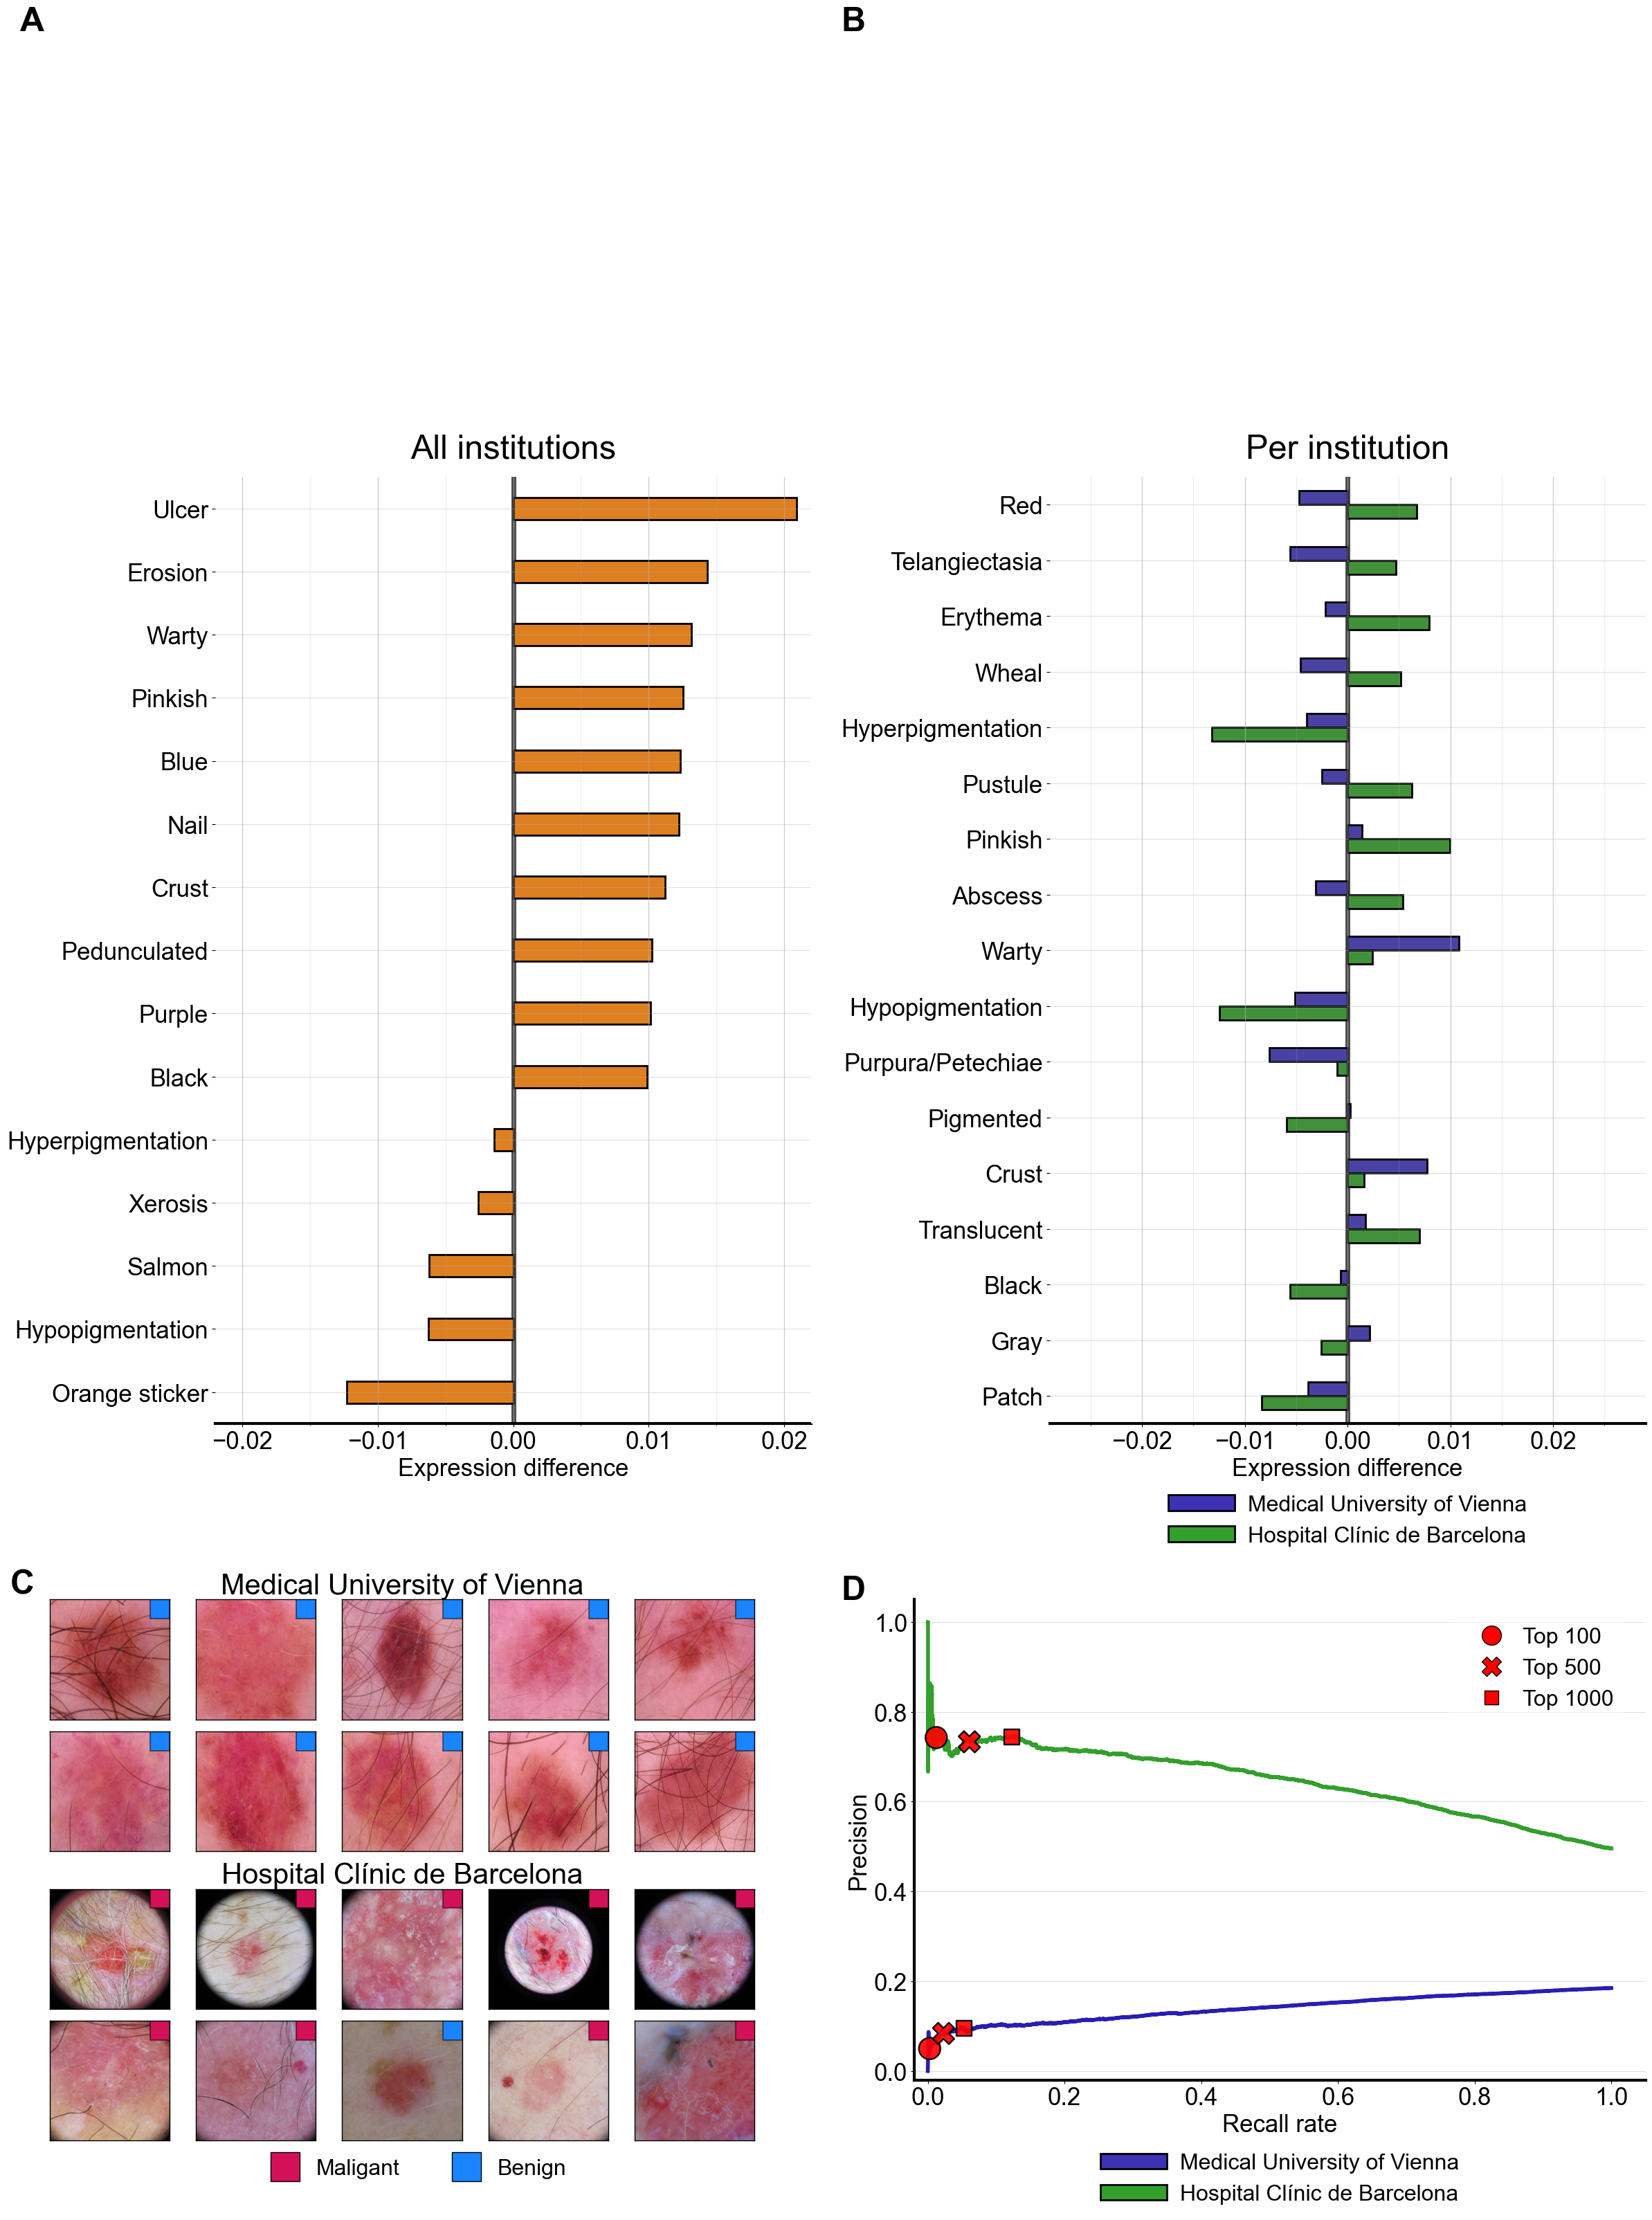

In [108]:
fig = plt.figure(figsize=(3*10, 3*(2+7+4) + 0.3*2   ))



example_per_concept=10
dataset_name="isic"
normalize=True

hospital_1="ViDIR Group, Department of Dermatology, Medical University of Vienna"
hospital_2="Hospital Clínic de Barcelona"

attribution_concept_list=[(hospital_1, "red"), 
                          (hospital_2,"red")]

red_color=np.array([212,17,89]) #np.array((222,40,40))
green_color=np.array([26,133,255]) #np.array((40,200,40))
[31, 120, 180], [51, 160, 44]
# two_color=[np.array([90, 0, 220]), np.array([51, 160, 44])]
#two_color=[np.array([31, 120, 180]), np.array([51, 160, 44])]
two_color=[np.array([60, 50, 180]), np.array([51, 160, 44])]

plt.rcParams["axes.prop_cycle"]=cycler('color', [np.array(i)/256 for i in two_color])

box1 = gridspec.GridSpec(3, 1,
                         height_ratios=[2, 7, 4],
                         wspace=0.0,
                         hspace=0.3)

axd={}
for idx1, stage in enumerate(["overview", "institution","investigation"]):
    if stage=="overview":
        
        plot_key=stage
        ax=plt.Subplot(fig, box1[idx1])
        fig.add_subplot(ax) 
        axd[plot_key]=ax
        
    elif stage=="institution":
        box2 = gridspec.GridSpecFromSubplotSpec(1, 4,
                        subplot_spec=box1[idx1], wspace=0., hspace=0, width_ratios=[0.3, 1, 0.4, 1])
        
        for idx2, instituion_type in enumerate(["empty_all", "all", "empty_between",  "between"]):
            
            plot_key=f"{stage}_{instituion_type}"
            ax=plt.Subplot(fig, box2[idx2])
            fig.add_subplot(ax)
            axd[plot_key]=ax
        
#     elif stage=="investigation":        
#         box2 = gridspec.GridSpecFromSubplotSpec(len(attribution_concept_list), 1,
#                         subplot_spec=box1[idx1], wspace=0.0, hspace=0.1)        
#         for idx2, (attribution_name, concept_name) in enumerate(attribution_concept_list):
#             box3 = gridspec.GridSpecFromSubplotSpec(example_per_concept//10, 10,
#                                                     subplot_spec=box2[idx2], wspace=0, hspace=0.1)
#             for rank_num in range(example_per_concept):
                
#                 plot_key=f"{stage}_{attribution_name}_{concept_name}_{rank_num}"                
#                 ax=plt.Subplot(fig, box3[rank_num])
#                 fig.add_subplot(ax)
#                 axd[plot_key]=ax         
    elif stage=="investigation":
        box2 = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=box1[idx1], wspace=0.2, hspace=0.)        
        for idx2, investigation_type in enumerate(["example", "statistics"]):
            if investigation_type=="example":
                box3 = gridspec.GridSpecFromSubplotSpec(len(attribution_concept_list), 1,
                                subplot_spec=box2[idx2], wspace=0.0, hspace=0.15)
                for idx3, (attribution_name, concept_name) in enumerate(attribution_concept_list):
                    box4 = gridspec.GridSpecFromSubplotSpec(example_per_concept//5, 5,
                                                            subplot_spec=box3[idx3], wspace=0, hspace=0.1)
                    for rank_num in range(example_per_concept):
                        plot_key=f"{stage}_{attribution_name}_{concept_name}_{rank_num}"                
                        ax=plt.Subplot(fig, box4[rank_num])
                        fig.add_subplot(ax)
                        axd[plot_key]=ax                  
            elif investigation_type=="statistics":
#                 plot_key=f"{stage}_{investigation_type}_{statistics_split}"
#                 ax=plt.Subplot(fig, box2[idx2])
#                 fig.add_subplot(ax)
#                 axd[plot_key]=ax                                             
                box3 = gridspec.GridSpecFromSubplotSpec(2, 1,
                                subplot_spec=box2[idx2], wspace=0.0, hspace=0.25, height_ratios=[999, 1])
                for idx3, statistics_split in enumerate(["main", "empty"]):                
                    plot_key=f"{stage}_{investigation_type}_{statistics_split}"
                    ax=plt.Subplot(fig, box3[idx3])
                    fig.add_subplot(ax)
                    axd[plot_key]=ax                             
    
  
    
for plot_key in axd.keys():
    if 'overview' in plot_key:
        axd[plot_key].set_xticks([])
        axd[plot_key].set_yticks([])
        for axis in ['top','bottom','left','right']:
            axd[plot_key].spines[axis].set_linewidth(0) 
            
    if 'empty' in plot_key:
        axd[plot_key].set_xticks([])
        axd[plot_key].set_yticks([])
        for axis in ['top','bottom','left','right']:
            axd[plot_key].spines[axis].set_linewidth(0)             
            
            
for idx1, stage in enumerate(["overview", "institution", "investigation"]):
    if stage=="overview":
        plot_key=stage
        axd[plot_key].text(x=-0.01, y=1.0, transform=axd[plot_key].transAxes,
                             s="A", fontsize=35, weight='bold')            
        axd[plot_key].text(x=0.5, y=1.0, transform=axd[plot_key].transAxes,
                             s="B", fontsize=35, weight='bold')                    
        
    elif stage=="institution":
        box2 = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=box1[idx1], wspace=0.0, hspace=0.1)
        
        for idx2, instituion_type in enumerate(["empty_all", "all", "empty_between", "between"]):
            plot_key=f"{stage}_{instituion_type}"
            
            if instituion_type=="all":
                concept_diff_all_top=pd.concat([concept_diff_all.sort_values(ascending=False).iloc[:18],concept_diff_all.sort_values(ascending=False).iloc[-10:]])
                concept_diff_all_top=concept_diff_all_top.reset_index(name="diff")
                concept_diff_all_top=concept_diff_all_top.rename(columns={"index": "concept_name"})
                
                concept_diff_all_top=concept_diff_all_top[concept_diff_all_top["concept_name"].map(lambda x: check_concept_name(dataset_name=dataset_name, concept_name=x))]
                concept_diff_all_top["concept_name"]=concept_diff_all_top["concept_name"].map(shorten_concept_name)
                
                sns.barplot(y="concept_name", x="diff", 
                            data=concept_diff_all_top, 
                            edgecolor='black',
                            linewidth=2,
                            width=0.35,
                            color=np.array(Paired[12][7])/256,
                            #color=(0.8, 0.8, 0.8, 0),
                            #palette="vlag",
                            ax=axd[plot_key])
                
                axd[plot_key].set_title("All institutions", pad=20, fontsize=35)
                axd[plot_key].set_xlim(-0.022, 0.022)
                
                
                #3################################################################################
#                 axd[plot_key+"_inner"] = axd[plot_key].inset_axes(
#                                     #loc='lower center',
#                                     #bbox_to_anchor=(0.5,-1,0,0),
#                                     bounds=(0.25, -0.12, 0.5, 0.02),
#                                     transform=axd[plot_key].transAxes)
                
# #                 axd[plot_key+"_inner"] = inset_axes(axd[plot_key],
# #                                                     width="100%",  # width = 5% of parent_bbox width
# #                                                     height="10%",
# #                                                     #loc='lower center',
# #                                                     #bbox_to_anchor=(0.5,-1,0,0),
# #                                                     bounds=(0,0,0.8,0.1),
# #                                                     bbox_transform=axd[plot_key].transAxes)

#                 cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1, vmax=1), cmap=sns.color_palette("icefire", as_cmap=True)),
#                                   cax=axd[plot_key+"_inner"],
#                                   format=ticker.FuncFormatter(lambda x, pos: f'{int(x):2d}'),
#                                   orientation='horizontal')
#                 cbar.outline.set_linewidth(0.3)
#                 cbar.set_ticks([-2, -1, 0, 1, 2])
                
                
            elif instituion_type=="between":
                
                concept_diff_institution["diff_abs"]=(concept_diff_institution[hospital_1]-concept_diff_institution[hospital_2]).abs()
                concept_diff_institution_top=concept_diff_institution.sort_values("diff_abs", ascending=False).iloc[:26]                
                concept_diff_institution_top=concept_diff_institution_top.drop(columns=["diff_abs"])
                #concept_diff_institution_top.plot.barh(ax=axd[plot_key])
                
                concept_diff_institution_top_1=concept_diff_institution_top[hospital_1].reset_index(name="diff")
                concept_diff_institution_top_1["source"]=hospital_1
                concept_diff_institution_top_2=concept_diff_institution_top[hospital_2].reset_index(name="diff")
                concept_diff_institution_top_2["source"]=hospital_2
                concept_diff_institution_top=pd.concat([concept_diff_institution_top_1, concept_diff_institution_top_2])                
                concept_diff_institution_top=concept_diff_institution_top.rename(columns={"index": "concept_name"})
                
                concept_diff_institution_top=concept_diff_institution_top[concept_diff_institution_top["concept_name"].map(lambda x: check_concept_name(dataset_name=dataset_name, concept_name=x))]
                concept_diff_institution_top["concept_name"]=concept_diff_institution_top["concept_name"].map(shorten_concept_name)
                
                sns.barplot(y="concept_name", x="diff", 
                            hue="source",
                            data=concept_diff_institution_top, 
                            hue_order=[hospital_1, hospital_2],
                            edgecolor='black',
                            linewidth=2,
                            width=0.5,
                            ax=axd[plot_key])                
                
                
                axd[plot_key].set_title("Per institution", pad=20, fontsize=35)
                axd[plot_key].set_xlim(-0.029, 0.029)
                
                legend_elements=[Patch(facecolor=two_color[0]/256, 
                                       edgecolor="black", linewidth=2, label=shorten_hospital_name(hospital_1)),
                                 Patch(facecolor=two_color[1]/256, 
                                       edgecolor="black", linewidth=2, label=shorten_hospital_name(hospital_2))]
#                 legend_elements = [Line2D([0], [0], color=np.array(Paired[12][1])/256, linestyle=['-'][0], linewidth=8, label=shorten_hospital_name(hospital_1)),
#                                    Line2D([0], [0], color=np.array(Paired[12][3])/256, linestyle=['-'][0], linewidth=8, label=shorten_hospital_name(hospital_2)),
#                                   ]
                axd[plot_key].legend(handles=legend_elements, 
                            ncol=1, 
                            handlelength=3,
                            handletextpad=0.6, 
                            columnspacing=1.5,
                            fontsize=23,
                            loc='lower center', bbox_to_anchor=(0.5, -0.15))                   
                
                
            if instituion_type=="all" or instituion_type=="between":
                axd[plot_key].axvline(x=0, ymin=0, ymax=1, color='black', alpha=0.7, linewidth=5, zorder=-5)

                for axis in ['top','bottom','left','right']:
                    axd[plot_key].spines[axis].set_linewidth(3)                

                axd[plot_key].set_xlabel('Expression difference', fontsize=25)

                axd[plot_key].spines['right'].set_visible(False)
                axd[plot_key].spines['left'].set_visible(False)
                axd[plot_key].spines['top'].set_visible(False)   

                axd[plot_key].xaxis.set_major_locator(MultipleLocator(0.010))
                axd[plot_key].xaxis.set_minor_locator(MultipleLocator(0.005))
                axd[plot_key].xaxis.grid(True, which='major', linewidth=1, alpha=0.6)
                axd[plot_key].xaxis.grid(True, which='minor', linewidth=1, alpha=0.2)

                axd[plot_key].yaxis.grid(True, which='major', linewidth=0.5, alpha=0.6)

                axd[plot_key].tick_params(axis='x', which='major', labelsize=25)
                #axd[plot_key].tick_params(axis='y', which='major', labelsize=25, pad=-100)
                axd[plot_key].tick_params(axis='y', which='major', labelsize=25)
                axd[plot_key].set_ylabel(None)
                #axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.5, alpha=0.2)            
            
            
            if instituion_type=="empty_all":
                pass
#                 axd[plot_key].text(x=-0.1, y=1.0, transform=axd[plot_key].transAxes,
#                                      s="A", fontsize=35, weight='bold')              
                
                #axd[plot_key].set_ylabel('Concepts', fontsize=30)
                
                
            if instituion_type=="empty_between":
                pass
#                 axd[plot_key].text(x=-0.0, y=1.0, transform=axd[plot_key].transAxes,
#                                      s="B", fontsize=35, weight='bold')  
        
        
    elif stage=="investigation":       
        for idx2, investigation_type in enumerate(["example", "statistics"]):
            
            if investigation_type=="example":
                for idx3, (attribution_name, concept_name) in enumerate(attribution_concept_list):            

                    subset_idx=get_subset_index(dataset_name=dataset_name, metadata_all=variable_dict[dataset_name]["metadata_all"], attribution=attribution_name)
#                     subset_idx=get_subset_index(dataset_name=dataset_name, metadata_all=variable_dict[dataset_name]["metadata_all"], attribution="all")
                    valid_idx=variable_dict[dataset_name]["valid_idx"]
                    subset_idx_select=(valid_idx==True)&(subset_idx)
                    #idx_neg=(y_pos==False)&(valid_idx==True)&(subset_idx)            

                    print(subset_idx)
                    similaity_score=calculate_similaity_score(
                                    image_features_norm=variable_dict[dataset_name]["image_features_norm"],
                                    prompt_target_embedding_norm=variable_dict[dataset_name]["prompt_info"][concept_name]["prompt_target_embedding_norm"],
                                    prompt_ref_embedding_norm=variable_dict[dataset_name]["prompt_info"][concept_name]["prompt_ref_embedding_norm"],
                                    normalize=normalize)

                    image_idx_list=pd.Series(similaity_score)[subset_idx_select
                                                             ].sort_values(ascending=False).index.tolist()
                    image_idx_list=np.random.default_rng(10).permutation(image_idx_list[:100])
                    image_idx_list=np.random.default_rng(10).permutation(image_idx_list)
                    #image_idx_list=image_idx_list[:1][::-1][:10]
                                        
                    #image_idx_list=image_idx_list[:50]
                    #np.random.
                    plot_key=f"{stage}_{attribution_name}_{concept_name}_{rank_num}"
                    count=0
                    rank_num=0
                    while rank_num<example_per_concept:
                        if check_image(dataset_name, image_idx_list[count]):
                            pass
                        else:
                            count+=1
                            continue

                        plot_key=f"{stage}_{attribution_name}_{concept_name}_{rank_num}"                

                        item=variable_dict[dataset_name]["dataloader"].dataset.getitem(image_idx_list[count])
                        #image=
                        axd[plot_key].imshow(item["image"].resize((300, 300)))

                        if item["metadata"]["benign_malignant_bool"]==True:
        #                     axd[plot_key].scatter(x=[0.9], y=[0.9], s=400, 
        #                                linewidths=2,
        #                                edgecolor=np.array((0,0,0))/256,
        #                                color=np.array((222,40,40))/256,
        #                                marker="o",
        #                                transform=axd[plot_key].transAxes)  

        #                     axd[plot_key].scatter(x=[0.9], y=[0.9], s=600, 
        #                                linewidths=1.5,
        #                                edgecolor=np.array((1,1,1))/256,
        #                                color=np.array((1,1,1,0))/256,
        #                                marker="o",
        #                                transform=axd[plot_key].transAxes) 
        #                     axd[plot_key].scatter(x=[0.9], y=[0.9], s=300, 
        #                                linewidths=5,
        #                                edgecolor=np.array((222,40,40))/256,
        #                                color=np.array((1,1,1,0))/256,
        #                                marker="o",
        #                                transform=axd[plot_key].transAxes) 

        #                     axd[plot_key].scatter(x=[0.9], y=[0.9], s=100, 
        #                                linewidths=1,
        #                                edgecolor=np.array((1,1,1))/256,
        #                                color=np.array((1,1,1,0))/256,
        #                                marker="o",
        #                                transform=axd[plot_key].transAxes)  

        #                     axd[plot_key].scatter(x=[0.9], y=[0.9], s=1800, 
        #                                linewidths=1,
        #                                edgecolor=np.array((0,0,0))/256,
        #                                color=np.array((222,40,40))/256,
        #                                marker=".",
        #                                transform=axd[plot_key].transAxes) 

                            axd[plot_key].scatter(x=[0.92], y=[0.92], s=400, 
                                       linewidths=1.5,
                                       edgecolor=np.array((0,0,0, 120))/256,
                                       #color=np.array((222,40,40))/256,
                                        color=red_color/256,
                                       marker="s",
                                       transform=axd[plot_key].transAxes)     




                        elif item["metadata"]["benign_malignant_bool"]==False:
        #                     axd[plot_key].scatter(x=[0.9], y=[0.9], s=600, 
        #                                linewidths=1,
        #                                 edgecolor=np.array((0,0,0))/256,
        #                                 color=np.array((40,200,40))/256,
        #                                marker="X",
        #                                transform=axd[plot_key].transAxes)

                            axd[plot_key].scatter(x=[0.92], y=[0.92], s=400, 
                                       linewidths=1.5,
                                       edgecolor=np.array((0,0,0, 120))/256,
                                       #color=np.array((40,200,40))/256,
                                       color=green_color/256,
                                       marker="s",
                                       transform=axd[plot_key].transAxes)                 

                        else:
                            raise NotImplementedError

                        #.scatter(x=[1,1], y=[1, 1], c='r', s=40)
                        #print(axd[plot_key].get_legend())
                        axd[plot_key].set_xticks([])
                        axd[plot_key].set_yticks([])        

                        if rank_num==2:   
                            #axd[plot_key].set_ylabel(shorten_attribution_name(attribution_name, very_short=True), fontsize=30, zorder=-10)
                            axd[plot_key].set_title(shorten_hospital_name(attribution_name), fontsize=30, zorder=-10)
                            #shorten_hospital_name(hospital_1)
                        if rank_num==0 and idx3==0:
                            axd[plot_key].text(x=-0.33, y=1.05, transform=axd[plot_key].transAxes,
                                                 s="C", fontsize=35, weight='bold')



        #                     legend_elements=[Line2D([0], [0], marker='x', color=np.array((222,40,40))/256,), 
        #                                      Line2D([0], [0], marker='x', color=np.array((40,200,40))/256),]


                            legend_elements = [Line2D([0], [0], 
                                                      marker='s', #marker='o'
                                                      color=(1,1,1,1), 
                                                      markerfacecolor=red_color/256, 
                                                      markeredgecolor=np.array((0,0,0))/256, 
                                                      markersize=30, 
                                                      label="Maligant"),
                                               Line2D([0], [0], 
                                                      marker='s', #marker='o'
                                                      color=(1,1,1,1), 
                                                      markerfacecolor=green_color/256, 
                                                      markeredgecolor=np.array((0,0,0))/256, 
                                                      markersize=30, label="Benign"),]        

                            axd[plot_key].legend(handles=legend_elements, 
                                                ncol=2, 
                                                handlelength=3,
                                                handletextpad=-0.1, 
                                                columnspacing=1.5,
                                                fontsize=23,
                                                loc='lower center', 
                                                bbox_to_anchor=(3., -4))  
#                             axd[plot_key].legend(handles=legend_elements, 
#                                                 ncol=1, 
#                                                 handlelength=3,
#                                                 handletextpad=-0.1, 
#                                                 columnspacing=1.5,
#                                                 fontsize=23,
#                                                 loc='lower center', 
#                                                 bbox_to_anchor=(3., -4))  

                        for axis in ['top','bottom','left','right']:
                            axd[plot_key].spines[axis].set_linewidth(1)      

                        rank_num+=1
                        count+=1

#                     if idx3==0 and rank_num==0:
#                         axd[plot_key].text(x=-0.0, y=1.0, transform=axd[plot_key].transAxes,
#                                          s="D", fontsize=35, weight='bold')  
                        
            if investigation_type=="statistics":           
                for idx3, statistics_split in enumerate(["main", "empty"]):
                    if statistics_split=="empty":
                        continue
                    plot_key=f"{stage}_{investigation_type}_{statistics_split}"

                    similaity_score=calculate_similaity_score(
                                    image_features_norm=variable_dict[dataset_name]["image_features_norm"],
                                    prompt_target_embedding_norm=variable_dict[dataset_name]["prompt_info"][concept_name]["prompt_target_embedding_norm"],
                                    prompt_ref_embedding_norm=variable_dict[dataset_name]["prompt_info"][concept_name]["prompt_ref_embedding_norm"],
                                    normalize=normalize)                

                    #axd[plot_key].plot(np.arange(0,1,0.01),np.arange(0,1,0.01),c=(0.8,0.8,0.8,0.8),linewidth=4.0,linestyle='--')

                    top_record_list=[]
                    for idx4, (attribution_name, concept_name) in enumerate(attribution_concept_list):
                        subset_idx=get_subset_index(dataset_name=dataset_name, metadata_all=variable_dict[dataset_name]["metadata_all"], attribution=attribution_name)
                        valid_idx=variable_dict[dataset_name]["valid_idx"]
                        subset_idx_select=(valid_idx==True)&(subset_idx)



                        metadata_all_statistics_select=variable_dict[dataset_name]["metadata_all"][subset_idx_select]
                        similaity_select=similaity_score[subset_idx_select]

    #                     fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true=metadata_all_statistics_select["benign_malignant_bool"], y_score=similaity_select, drop_intermediate=False)
    #                     print(len(metadata_all_statistics_select),len(tpr))
    #                     axd[plot_key].plot(fpr, tpr, 
    #                                        color=[np.array(Paired[12][1])/256, np.array(Paired[12][3])/256][idx3], linewidth=4)


                        if idx4==0:
                            precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true=metadata_all_statistics_select["benign_malignant_bool"], probas_pred=similaity_select)
    #                         precision, recall, thresholds=precision[:-1], recall[:-1], thresholds[:-1]

                            assert (len(precision)-1)==(len(recall)-1)==len(thresholds), f"{len(precision)}, {len(recall)}, {len(thresholds)}"
                            precision, recall=precision[:-1], recall[:-1]
    #                         precision, recall, thresholds=precision[:-30], recall[:-30], thresholds[:-30]

                            print(attribution_name, )
                            print(precision)
                            print(recall)
                            print(thresholds)


                            axd[plot_key].plot(recall,precision , 
                                               color=[np.array([ 40,  30, 180])/256, 
                                                      two_color[1]/256][idx4], linewidth=4)                       
    #                         plt.plot(recall, precision,
    #                                            color=[np.array(Paired[12][1])/256, np.array(Paired[12][3])/256][idx3], linewidth=4)                                        

                            sns.scatterplot(x="recall", y="precision", 
                                            style="top_n",
                                            color="red",                                        
                                            s=500,
                                            alpha=0.9,
                                            zorder=10,
                                            edgecolor='black',
                                        data=pd.DataFrame([{"precision": precision[-top_n], "recall": recall[-top_n], "top_n": top_n} for top_n in [100, 500, 1000]]),
                                           ax=axd[plot_key]) 

                            #aaa
                        else:
                            precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true=metadata_all_statistics_select["benign_malignant_bool"], probas_pred=similaity_select)
    #                         precision, recall, thresholds=precision[:-1], recall[:-1], thresholds[:-1]

                            assert (len(precision)-1)==(len(recall)-1)==len(thresholds), f"{len(precision)}, {len(recall)}, {len(thresholds)}"
                            precision, recall=precision[:-1], recall[:-1]
    #                         precision, recall, thresholds=precision[:-30], recall[:-30], thresholds[:-30]                        


                            print(attribution_name, )
                            print(precision)
                            print(recall)
                            print(thresholds)    

                            axd[plot_key].plot(recall,precision , 
                                               color=[two_color[0]/256, 
                                                      two_color[1]/256][idx4], linewidth=4)                                                            

                            sns.scatterplot(x="recall", y="precision", 
                                            style="top_n",
                                            color="red",
                                            s=500,
                                            alpha=0.9,
                                            zorder=10,        
                                            edgecolor='black',
                                        data=pd.DataFrame([{"precision": precision[-top_n], "recall": recall[-top_n], "top_n": top_n} for top_n in [100, 500, 1000]]),
                                           ax=axd[plot_key])                        


    #                     fpr, tpr, thresholds = sklearn.metrics.precision_recall_curve(y_true=metadata_all_statistics_select["benign_malignant_bool"], probas_pred=similaity_select)
    #                     axd[plot_key].plot(fpr, tpr, 
    #                                        color=[np.array(Paired[12][1])/256, np.array(Paired[12][3])/256][idx3], linewidth=4)                    

                        #print(len(metadata_all_statistics_select),len(tpr))

    #                     sns.scatterplot(x="fpr", y="tpr", 
    #                                     s=400,
    #                                 data=pd.DataFrame([{"fpr": fpr[top_n], "tpr": tpr[top_n], "top_n": top_n} for top_n in [100, 500, 1000]]),
    #                                    ax=axd[plot_key])



                        print(attribution_name, metadata_all_statistics_select["benign_malignant_bool"].sum()/len(metadata_all_statistics_select["benign_malignant_bool"]))


                        num_top_list=[]
                        num_true_list=[]
                        for num_top in [50, 100, 200, 500, 1000, 2000]:
                            num_top_list.append(num_top)
                            num_true_list.append(metadata_all_statistics_select["benign_malignant_bool"][np.argsort(similaity_select)[::-1][:num_top]].sum()/num_top)
                            top_record_list.append({"num_top": num_top,
                                                    "proportion": metadata_all_statistics_select["benign_malignant_bool"][np.argsort(similaity_select)[::-1][:num_top]].sum()/num_top,
                                                    "attribution_name": attribution_name
                                                   })
                    #b=sns.barplot(y="proportion", x="num_top", hue="attribution_name", data=pd.DataFrame(top_record_list), ax=axd[plot_key])
                    #b.legend_.remove()
                    #axd[plot_key].plot(num_top_list, num_true_list)

                    legend_elements = [Line2D([0], [0], marker='.', color=(1,1,1,1), 
                                              markerfacecolor="red", 
                                              markeredgecolor=np.array((0,0,0))/256, 
                                              markersize=40, 
                                              label="Top 100"),
                                       Line2D([0], [0], marker='X', color=(1,1,1,1), 
                                              markerfacecolor="red", 
                                              markeredgecolor=np.array((0,0,0))/256, 
                                              markersize=20, label="Top 500"),
                                       Line2D([0], [0], marker='s', color=(1,1,1,1), 
                                              markerfacecolor="red", 
                                              markeredgecolor=np.array((0,0,0))/256, 
                                              markersize=15, label="Top 1000"),                                   

                                      ]        

                    leg=axd[plot_key].legend(handles=legend_elements, 
                                        ncol=1, 
                                        handlelength=3,
                                        handletextpad=-0.1, 
                                        columnspacing=1.5,
                                        fontsize=23,
                                        loc='lower center', 
                                        #bbox_to_anchor=(0.85, 0.75)
                                        bbox_to_anchor=(0.85, 0.73),
                                        facecolor='white', framealpha=0.5
                                            )     

                    axd[plot_key].add_artist(leg)



                    legend_elements=[Patch(facecolor=two_color[0]/256, 
                                           edgecolor="black", linewidth=2, label=shorten_hospital_name(hospital_1)),
                                     Patch(facecolor=two_color[1]/256, 
                                           edgecolor="black", linewidth=2, label=shorten_hospital_name(hospital_2))]
    #                 legend_elements = [Line2D([0], [0], color=np.array(Paired[12][1])/256, linestyle=['-'][0], linewidth=8, label=shorten_hospital_name(hospital_1)),
    #                                    Line2D([0], [0], color=np.array(Paired[12][3])/256, linestyle=['-'][0], linewidth=8, label=shorten_hospital_name(hospital_2)),
    #                                   ]
                    axd[plot_key].legend(handles=legend_elements, 
                                ncol=1, 
                                handlelength=3,
                                handletextpad=0.6, 
                                columnspacing=1.5,
                                fontsize=23,
                                loc='lower center', bbox_to_anchor=(0.5, -0.3))   #facecolor='white', framealpha=0.5               

                    for axis in ['top','bottom','left','right']:
                        axd[plot_key].spines[axis].set_linewidth(3)                


                    axd[plot_key].set_ylim(-0.02, 1.05)
                    axd[plot_key].set_xlim(-0.02, 1.05)
                    axd[plot_key].set_xlabel('Recall rate', fontsize=25)
                    axd[plot_key].set_ylabel('Precision', fontsize=25)

                    axd[plot_key].spines['top'].set_visible(False)
                    axd[plot_key].spines['right'].set_visible(False)   

                    axd[plot_key].xaxis.set_major_locator(MultipleLocator(0.2))
    #                 axd[plot_key].xaxis.set_minor_locator(MultipleLocator(0.05))
    #                 axd[plot_key].xaxis.grid(True, which='major', linewidth=1, alpha=0.6)
    #                 axd[plot_key].xaxis.grid(True, which='minor', linewidth=1, alpha=0.2)

                    axd[plot_key].yaxis.set_major_locator(MultipleLocator(0.2))
                    #axd[plot_key].yaxis.set_minor_locator(MultipleLocator(0.05))                
                    axd[plot_key].yaxis.grid(True, which='major', linewidth=0.5, alpha=0.6)                
                    axd[plot_key].yaxis.grid(True, which='minor', linewidth=0.5, alpha=0.2)   

                    axd[plot_key].tick_params(axis='x', which='major', labelsize=25)
                    axd[plot_key].tick_params(axis='y', which='major', labelsize=25)                

                    axd[plot_key].set_title("")


                    axd[plot_key].text(x=-0.1, y=1.0, transform=axd[plot_key].transAxes,
                                             s="D", fontsize=35, weight='bold')                  
                        
# fig.savefig(log_dir/"plots"/"data_audit_main.png", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"data_audit_main.jpg", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"data_audit_main.svg", bbox_inches='tight')
# fig.savefig(log_dir/"plots"/"data_audit_main.pdf", bbox_inches='tight')
#plt.close(fig)                    

In [ ]:
concept_diff_institution.sort_values("diff_abs", ascending=False).iloc[:20]                

In [ ]:
np.array(Paired[12][1])/256, np.array(Paired[12][3])/256

In [ ]:
(Paired[12][1],Paired[12][3])

In [ ]:
variable_dict["clinical_fd_clean"]["benchmark_dict_list"]

In [ ]:
skincon_cols

In [ ]:
concept_diff_all_top

In [ ]:
skincon_cols

In [ ]:
thresholds

In [ ]:
from matplotlib.patches import Patch

In [ ]:
from matplotlib.lines import Line2D

In [ ]:
from sklearn.model_selection import train_test_split
from MONET.datamodules.components.base_dataset import BaseDataset

def get_test_data(dataloader, metadata_all, valid_idx, y_pos, n_px=None):
    metadata_all_new = dataloader.dataset.metadata_all.copy()
    metadata_all_new["label"]=y_pos.astype(int)
    # metadata_all_new=metadata_all_new.iloc[list(true_set.union(false_set))]
    print("test:", len(metadata_all_new))
    
    if n_px is None:
        n_px=dataloader.dataset.n_px    
    
    data_all = BaseDataset(
        image_path_or_binary_dict=dataloader.dataset.image_path_dict,
        n_px=n_px,
        norm_mean=dataloader.dataset.transforms_aftertensor.transforms[1].mean,
        norm_std=dataloader.dataset.transforms_aftertensor.transforms[1].std,
        augment=False,
        metadata_all=metadata_all_new,
        integrity_level="weak",
        return_label=["label"],
    )    

    from MONET.utils.loader import custom_collate
    all_dataloader = torch.utils.data.DataLoader(
        dataset=data_all,
        batch_size=64,
        num_workers=4,
        pin_memory=False,
        persistent_workers=False,
        shuffle=False,
        collate_fn=custom_collate,
    )    
          
    
    return all_dataloader

In [ ]:
for dataset_name in ["isic"]: 
    x=get_test_data(dataloader=variable_dict["isic"]["dataloader"], 
                  metadata_all=variable_dict["isic"]["metadata_all"],
                  valid_idx=variable_dict["isic"]["valid_idx"],
                  y_pos=variable_dict["isic"]["y_pos"])
    variable_dict[dataset_name].update({f"classifier_dataloader_all": x}) 

In [ ]:
for dataset_name in ["isic"]: 
    x=get_test_data(dataloader=variable_dict["isic"]["dataloader"], 
                  metadata_all=variable_dict["isic"]["metadata_all"],
                  valid_idx=variable_dict["isic"]["valid_idx"],
                  y_pos=variable_dict["isic"]["y_pos"], n_px=299)
    variable_dict[dataset_name].update({f"classifier_dataloader299_all": x}) 

In [ ]:
from sklearn.model_selection import train_test_split
from MONET.datamodules.components.base_dataset import BaseDataset

def get_training_data(dataloader, metadata_all, valid_idx, y_pos, subset_idx_train, n_px=None):
    metadata_all_new = dataloader.dataset.metadata_all.copy()
    metadata_all_new["label"]=y_pos.astype(int)
    metadata_all_new_train=metadata_all_new[valid_idx&subset_idx_train]
    # metadata_all_new=metadata_all_new.iloc[list(true_set.union(false_set))]

    train_idx, val_idx = train_test_split(metadata_all_new_train.index, test_size=0.2, random_state=42)
    
    print("train:", len(metadata_all_new_train))

    if n_px is None:
        n_px=dataloader.dataset.n_px
    
    data_train = BaseDataset(
        image_path_or_binary_dict=dataloader.dataset.image_path_dict,
        n_px=n_px,
        norm_mean=dataloader.dataset.transforms_aftertensor.transforms[1].mean,
        norm_std=dataloader.dataset.transforms_aftertensor.transforms[1].std,
        augment=False,
        metadata_all=metadata_all_new_train.loc[train_idx],
        integrity_level="weak",
        return_label=["label"],
    )

    data_val = BaseDataset(
        image_path_or_binary_dict=dataloader.dataset.image_path_dict,
        n_px=n_px,
        norm_mean=dataloader.dataset.transforms_aftertensor.transforms[1].mean,
        norm_std=dataloader.dataset.transforms_aftertensor.transforms[1].std,
        augment=False,
        metadata_all=metadata_all_new_train.loc[val_idx],
        integrity_level="weak",
        return_label=["label"],
    )

    from MONET.utils.loader import custom_collate

    train_dataloader = torch.utils.data.DataLoader(
        dataset=data_train,
        batch_size=64,
        num_workers=4,
        pin_memory=False,
        persistent_workers=False,
        shuffle=True,
        collate_fn=custom_collate,
    )
    val_dataloader = torch.utils.data.DataLoader(
        dataset=data_val,
        batch_size=64,
        num_workers=4,
        pin_memory=False,
        persistent_workers=False,
        shuffle=False,
        collate_fn=custom_collate,
    )       
    
    return train_dataloader, val_dataloader

In [ ]:
for dataset_name in ["isic"]: 
    x=get_training_data(dataloader=variable_dict["isic"]["dataloader"], 
                  metadata_all=variable_dict["isic"]["metadata_all"],
                  valid_idx=variable_dict["isic"]["valid_idx"],
                  y_pos=variable_dict["isic"]["y_pos"],
                  subset_idx_train=get_subset_index(dataset_name="isic", metadata_all=variable_dict["isic"]["metadata_all"], attribution=hospital_1),
                 )
    variable_dict[dataset_name].update({f"classifier_dataloader_{hospital_1}": x}) 
    
    x=get_training_data(dataloader=variable_dict["isic"]["dataloader"], 
                  metadata_all=variable_dict["isic"]["metadata_all"],
                  valid_idx=variable_dict["isic"]["valid_idx"],
                  y_pos=variable_dict["isic"]["y_pos"],
                  subset_idx_train=get_subset_index(dataset_name="isic", metadata_all=variable_dict["isic"]["metadata_all"], attribution=hospital_2),
                    )
    variable_dict[dataset_name].update({f"classifier_dataloader_{hospital_2}": x}) 

In [ ]:
for dataset_name in ["isic"]: 
    x=get_training_data(dataloader=variable_dict["isic"]["dataloader"], 
                  metadata_all=variable_dict["isic"]["metadata_all"],
                  valid_idx=variable_dict["isic"]["valid_idx"],
                  y_pos=variable_dict["isic"]["y_pos"],
                  subset_idx_train=get_subset_index(dataset_name="isic", metadata_all=variable_dict["isic"]["metadata_all"], attribution=hospital_1),
                  n_px=299
                 )
    variable_dict[dataset_name].update({f"classifier_dataloader299_{hospital_1}": x}) 
    
    x=get_training_data(dataloader=variable_dict["isic"]["dataloader"], 
                  metadata_all=variable_dict["isic"]["metadata_all"],
                  valid_idx=variable_dict["isic"]["valid_idx"],
                  y_pos=variable_dict["isic"]["y_pos"],
                  subset_idx_train=get_subset_index(dataset_name="isic", metadata_all=variable_dict["isic"]["metadata_all"], attribution=hospital_2),
                  n_px=299
                  )
    variable_dict[dataset_name].update({f"classifier_dataloader299_{hospital_2}": x}) 

In [ ]:
from MONET.datamodules.components.base_dataset import BaseDataset

In [ ]:
!gpustat

In [ ]:
import torchvision
from torch import nn
from torch.nn import functional as F
from torchmetrics import AUROC

class Classifier(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.backbone = torchvision.models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V1")

        for param in self.backbone.parameters():
            param.requires_grad = True
            # pass

        head_in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.head = nn.Linear(head_in_features, output_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x
    
class Inception(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.inception = torchvision.models.inception_v3(weights="Inception_V3_Weights.IMAGENET1K_V1")
        self.fc = nn.Linear(2048, output_dim)

    def forward(self, x):
        x = self.input_to_representation(x)
        x = self.fc(x)
        # N x 200
        return x

    def input_to_representation(self, x):
        # N x 3 x 299 x 299
        x = self.inception.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.inception.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.inception.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = self.inception.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.inception.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.inception.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = self.inception.maxpool2(x)
        # N x 192 x 35 x 35
        x = self.inception.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.inception.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.inception.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.inception.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.inception.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.inception.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.inception.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.inception.Mixed_6e(x)
        # N x 768 x 17 x 17
        aux: Optional[torch.Tensor] = None
        if self.inception.AuxLogits is not None:
            if self.inception.training:
                aux = self.inception.AuxLogits(x)
        # N x 768 x 17 x 17
        x = self.inception.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.inception.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.inception.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = self.inception.avgpool(x)
        # N x 2048 x 1 x 1
        x = self.inception.dropout(x)
        # N x 2048 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 2048
        return x    


class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
        
def train_classifier(train_dataloader, val_dataloader, test_dataloader, classifier_type="resnet"):
    if classifier_type=="resnet":
        classifier = Classifier(output_dim=1)
    elif classifier_type=="inception":
        classifier = Inception(output_dim=1)
    classifier_device = "cuda:3"
    classifier.to(classifier_device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=2, verbose=True)
    early_stopper = EarlyStopper(patience=5, min_delta=0)

    train_auroc = AUROC(task="binary")
    val_auroc = AUROC(task="binary")
    for epoch in range(20):
        train_loss = 0
        train_correct = 0
        classifier.train()
        for batch in tqdm.tqdm(train_dataloader):
            image, label = batch["image"].to(classifier_device), batch["label"].to(classifier_device)
            logits = classifier(image)
            weight = torch.ones(label.shape[0], device=label.device)
            loss = F.binary_cross_entropy_with_logits(
                input=logits[:, 0], target=(label == 1).float()
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * image.size(0)
            train_auroc.update(logits, (label == 1))

        val_loss = 0
        classifier.eval()
        with torch.no_grad():
            for batch in tqdm.tqdm(val_dataloader):
                image, label = batch["image"].to(classifier_device), batch["label"].to(
                    classifier_device
                )
                logits = classifier(image)
                loss = F.binary_cross_entropy_with_logits(
                    input=logits[:, 0], target=(label == 1).float()
                )
                val_loss += loss.item() * image.size(0)
                val_auroc.update(logits, (label == 1))

        print(
            f"Train loss: {train_loss/len(train_dataloader.dataset):.3f} AUROC: {train_auroc.compute():.3f} Val loss: {val_loss/len(val_dataloader.dataset):.3f} AUROC: {val_auroc.compute():.3f}"
        )
        scheduler.step(val_loss)
        if early_stopper.early_stop(val_loss):
            print("break")
            break
        train_auroc.reset()
        val_auroc.reset() 
        
    test_auroc = AUROC(task="binary")    
    test_loss = 0
    classifier.eval()
    with torch.no_grad():
        for batch in tqdm.tqdm(test_dataloader):
            image, label = batch["image"].to(classifier_device), batch["label"].to(
                classifier_device
            )
            logits = classifier(image)
            loss = F.binary_cross_entropy_with_logits(
                input=logits[:, 0], target=(label == 1).float()
            )
            test_loss += loss.item() * image.size(0)
            test_auroc.update(logits, (label == 1))

    print(
        f"Test loss: {test_loss/len(test_dataloader.dataset):.3f} AUROC: {test_auroc.compute():.3f}"
    )   
    return classifier

In [ ]:
!gpustat

In [ ]:
classifier_device = "cuda:3"

In [ ]:
for dataset_name in ["isic"]:
    x=train_classifier(train_dataloader=variable_dict["isic"][f"classifier_dataloader_{hospital_1}"][0], 
                       val_dataloader=variable_dict["isic"][f"classifier_dataloader_{hospital_1}"][1],
                       test_dataloader=variable_dict["isic"][f"classifier_dataloader_{hospital_2}"][0])    
    variable_dict[dataset_name].update({f"classifier_model_{hospital_1}": x}) 
    
    x=train_classifier(train_dataloader=variable_dict["isic"][f"classifier_dataloader_{hospital_2}"][0], 
                       val_dataloader=variable_dict["isic"][f"classifier_dataloader_{hospital_2}"][1],
                       test_dataloader=variable_dict["isic"][f"classifier_dataloader_{hospital_1}"][0])    
    variable_dict[dataset_name].update({f"classifier_model_{hospital_2}": x})     

In [ ]:
for dataset_name in ["isic"]:
    x=train_classifier(train_dataloader=variable_dict["isic"][f"classifier_dataloader299_{hospital_1}"][0], 
                       val_dataloader=variable_dict["isic"][f"classifier_dataloader299_{hospital_1}"][1],
                       test_dataloader=variable_dict["isic"][f"classifier_dataloader299_{hospital_2}"][0],
                      classifier_type="inception")    
    variable_dict[dataset_name].update({f"classifier_inceptionmodel_{hospital_1}": x}) 
    
    x=train_classifier(train_dataloader=variable_dict["isic"][f"classifier_dataloader299_{hospital_2}"][0], 
                       val_dataloader=variable_dict["isic"][f"classifier_dataloader299_{hospital_2}"][1],
                       test_dataloader=variable_dict["isic"][f"classifier_dataloader299_{hospital_1}"][0],
                        classifier_type="inception")
    variable_dict[dataset_name].update({f"classifier_inceptionmodel_{hospital_2}": x})     

In [ ]:
def get_logits(classifier, dataloader):
    def batch_func(batch):
        with torch.no_grad():
            image, label = batch["image"].to(classifier_device), batch["label"].to(
                classifier_device
            )        
            logits = classifier(image)
        # print(batch["metadata"])
        return {
            "logits": pd.Series(logits[:,0].cpu().numpy(), index=batch["metadata"].index),
            "metadata": batch["metadata"],
        }
    
    loader_applied = dataloader_apply_func(
        dataloader=dataloader,
        func=batch_func,
        collate_fn=custom_collate_per_key,
    )    
    return loader_applied

In [ ]:
for dataset_name in ["isic"]:
    logits_hospital_1=get_logits(classifier=variable_dict["isic"][f'classifier_model_{hospital_1}'],
              dataloader=variable_dict["isic"]['classifier_dataloader_all'],
              )
    variable_dict[dataset_name].update({f"classifier_model_{hospital_1}_eval": logits_hospital_1})
    
    logits_hospital_2=get_logits(classifier=variable_dict["isic"][f'classifier_model_{hospital_2}'],
              dataloader=variable_dict["isic"]['classifier_dataloader_all'],
              )   
    variable_dict[dataset_name].update({f"classifier_model_{hospital_2}_eval": logits_hospital_2})

In [ ]:
for dataset_name in ["isic"]:
    logits_hospital_1=get_logits(classifier=variable_dict["isic"][f'classifier_inceptionmodel_{hospital_1}'],
              dataloader=variable_dict["isic"]['classifier_dataloader_all'],
              )
    variable_dict[dataset_name].update({f"classifier_inceptionmodel_{hospital_1}_eval": logits_hospital_1})
    
    logits_hospital_2=get_logits(classifier=variable_dict["isic"][f'classifier_inceptionmodel_{hospital_2}'],
              dataloader=variable_dict["isic"]['classifier_dataloader_all'],
              )   
    variable_dict[dataset_name].update({f"classifier_inceptionmodel_{hospital_2}_eval": logits_hospital_2})

In [ ]:
variable_dict

In [ ]:
variable_dict=torch.load(log_dir/"experiment_results"/"data_audit.pt")

In [ ]:
print(1)

In [ ]:
# torch.save(variable_dict, log_dir/"experiment_results"/"data_audit_new.pt")

In [ ]:
def calculate_test_auc(metadata_all, 
                       logits, 
                       idx):
    return sklearn.metrics.roc_auc_score(y_true=metadata_all["label"].loc[idx].values.astype(int),
                             y_score=logits.loc[idx].values)

print(calculate_test_auc(metadata_all=variable_dict[dataset_name][f"classifier_model_{hospital_1}_eval"]["metadata"],
                  logits=variable_dict[dataset_name][f"classifier_model_{hospital_1}_eval"]["logits"],
                   idx=variable_dict["isic"][f"classifier_dataloader_{hospital_2}"][1].dataset.metadata_all.index))

print(calculate_test_auc(metadata_all=variable_dict[dataset_name][f"classifier_model_{hospital_1}_eval"]["metadata"],
                  logits=variable_dict[dataset_name][f"classifier_model_{hospital_1}_eval"]["logits"],
                   idx=variable_dict["isic"][f"classifier_dataloader_{hospital_1}"][1].dataset.metadata_all.index))


In [ ]:
print(calculate_test_auc(metadata_all=variable_dict[dataset_name][f"classifier_model_{hospital_1}_eval"]["metadata"],
                  logits=variable_dict[dataset_name][f"classifier_model_{hospital_1}_eval"]["logits"],
                   idx=variable_dict["isic"][f"classifier_dataloader_{hospital_1}"][0].dataset.metadata_all.index))

In [ ]:
print(calculate_test_auc(metadata_all=variable_dict[dataset_name][f"classifier_model_{hospital_2}_eval"]["metadata"],
                  logits=variable_dict[dataset_name][f"classifier_model_{hospital_2}_eval"]["logits"],
                   idx=variable_dict["isic"][f"classifier_dataloader_{hospital_1}"][1].dataset.metadata_all.index))

print(calculate_test_auc(metadata_all=variable_dict[dataset_name][f"classifier_model_{hospital_2}_eval"]["metadata"],
                  logits=variable_dict[dataset_name][f"classifier_model_{hospital_2}_eval"]["logits"],
                   idx=variable_dict["isic"][f"classifier_dataloader_{hospital_2}"][1].dataset.metadata_all.index))